<a href="https://colab.research.google.com/github/fsilvestrim/thesis/blob/master/Geo_Cam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Knowledge Extraction of Class Activation Maps
_by Filipe Ghesla Silvestrim_


This notebook contains the source code used during my master thesis research.<br>
The sequence as the code appears represents the chronological steps took during our experiments.<br>

Contents:
1. [Bootstrap](#boot) - section with all python imports, initializations, and utility methods;
2. [Class Activation Map Techniques](#cam) - section with the python implementation for CAM, Grad-CAM, and Grad-CAM++;
3. [Base models](#base) - section with the base PDN and KDN models;
4. [Unified Model](#um) - section with the BUM and XUM models;
5. [Knowledge Extraction Technique](#ket) - section with the implementation for the CAM knowledge extraction algorithm;
6. [Tests](#tests) - section with the experimental settings, visualization, and validation tools;

<br>
<hr>

# Bootstrap
<a name="boot"/>

This region contains the system initialization (Tensorflow, GPU, fixed random seeds, ...) and many other python functions created to support the development of the technique as utils methods.

In [71]:
# Raw imports

import os
import re
import PIL
import cv2
import time
import math
import shutil
import random
import pickle
import hashlib
import warnings
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tqdm import tqdm 
from scipy import ndimage
from matplotlib import cm
from textwrap import wrap
from sklearn.metrics import *
from IPython.display import Image, display
from mpl_toolkits.axes_grid1 import ImageGrid

np.seterr(divide='ignore', invalid='ignore')

%matplotlib inline

In [72]:
# Tensorflow and Keras imports

import tensorflow as tf
print(tf.__version__)
from tensorflow import keras
from keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution

enable_eager_execution()
print('Eager mode: %s' % tf.executing_eagerly())

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.6.0
Eager mode: True
Found GPU at: /device:GPU:0


In [73]:
# Fixing random seeds for more reproducible training results.
# Inspired by https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(123)
random.seed(123)
tf.random.set_seed(1234)

In [74]:
def safe_divide(a, b, abs=True):
  """Numpy safe division helper method
     Avoids nan or division by zero
    """
  val = 0 if type(a) is not np.ndarray else np.zeros(a.shape)

  if b != 0 and not math.isnan(b):
    val = np.divide(a, b)

  return np.int0(val) if abs else val

In [75]:
def resize_image(image, size):
  """Resizes an open cv image
     It uses scipy to interpolate the image to the new dimension
    """
  if len(image.shape) > 2:
    image = image.reshape(size[0], size[1])

  if image.shape[0] != size[0] or image.shape[1] != size[1]:
    width_zoom = size[0] / image.shape[0]
    height_zoom = size[1] / image.shape[1]
    image = sp.ndimage.zoom(image, (height_zoom, width_zoom), order=2)

  return image

In [76]:
def show_image(img, size, title=None, ax=None, alpha=1, cmap='Greys', rotation=0, stacked_imgs=[], fontsize=25):
  """Visual aid method to print one or more opencv images on this notebook
    """
  if size is not None:
    img = resize_image(img, size)
  # plot
  subplot = ax is not None

  if not subplot:
    plt.figure(facecolor='white')
    ax = plt.gca()

  ax.set_xticklabels([])
  ax.set_yticklabels([])

  if rotation != 0:
    img = scipy.ndimage.rotate(img, rotation)
  
  if not subplot:
    plt.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
      s_img = s_image.get('img').reshape(size[0], size[1])
      if rotation != 0:
        s_img = scipy.ndimage.rotate(s_img, rotation)
      plt.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

    plt.axis('off')

    if title is not None:
      title = "\n".join(wrap(title, size[0]))
      plt.title(title, fontsize=fontsize/2)
  
    plt.show()

  else:    
    if title is not None:
      title = "\n".join(wrap(title, size[0]*.5))
      ax.set_title(title, fontdict=None, loc='center', color="k", fontsize=fontsize)

    ax.imshow(img, cmap=cmap, alpha=alpha)
    for s_image in stacked_imgs:
        s_img = s_image.get('img').reshape(size[0], size[1])
        if rotation != 0:
          s_img = scipy.ndimage.rotate(s_img, rotation)
        ax.imshow(s_img, cmap=s_image.get('cmap') or 'Greys', alpha=s_image.get('alpha') or 0.5)

In [77]:
def show_heatmap(img, cam, size, resize=True, title=None, ax=None):
  """Visual aid method to print one heatmap image on this notebook
     The image is how in the jet color format
    """
  heatmap = get_heatmap(cam, size, resize)
  show_image(img, size, title=title, ax=ax, alpha=0.3, stacked_imgs=[{'img':heatmap, 'cmap':'jet'}])

In [78]:
def get_heatmap(cam, size, resize=True):
  """The heatmap image value is resized and then normalized
    """
  heatmap = cam / np.max(cam)
 
  if resize:
    heatmap = resize_image(heatmap, size)
 
  return heatmap

In [79]:
def show_prediction(image, truth, prediction, label_descriptions=None, size=(28,28)):
  """Helper method to pring the image of a network's prediction
    """
  prediction = np.argmax(prediction)
  prediction = prediction if label_descriptions is None else label_descriptions[prediction]
  truth = truth if label_descriptions is None else label_descriptions[truth]
  title = f"Prediction: {prediction} / Truth: {truth}"
  show_image(image, size, title)

In [80]:
def plot_model_score(score, history):
  """Plots the training graph from a Keras model
    """
  plt.figure(facecolor='white')
  plt.plot(history['loss'])
  plt.plot(history['val_loss'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.title("Loss: %.5f vs. Accuracy: %.5f" % (score[0], score[1]))
  plt.show() 

In [81]:
def load_model(name):
  """Loads a saved keras model from a file
    """
  model = keras.models.load_model("saved_model_%s" % name)
  history = pickle.load(open('saved_model_%s/history' % name, "rb"))

  return model, history

In [82]:
def save_model(model, history, name):
  """Save a trained keras model to a file
    """
  model.save("saved_model_%s" % name)

  with open('saved_model_%s/history' % name, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [83]:
def get_cam_layers(model):
  """Util method to get the last convolutional layer from a CNN
    """
  last_conv_layer = None
  last_layers = []
  conv_layers = []
  for layer in reversed(model.layers):
      if len(layer.output_shape) == 4 and last_conv_layer is None: # check to see if the layer has a 4D output
        last_conv_layer = layer
      if last_conv_layer is not None:
        conv_layers.insert(0, layer)
      else:
        last_layers.insert(0, layer)

  return conv_layers, last_layers

In [84]:
def get_layer(model, layer_name):
  """Util method to get a layer from a Keras model by its given name
    """
  for layer in model.layers:
    if layer.name == layer_name:
      return layer

  return None

In [85]:
def get_sample(test_set, idx=-1):
  """Helper method to easely get a given (or random) sample from a test-set
    """
  test_idx = random.randint(0, len(test_set[0])) if idx < 0 else idx
  test_image = test_set[0][test_idx]
  test_label = np.argmax(test_set[1][test_idx])

  return test_image, test_label, test_idx

In [86]:
def predict(model, image):
  """Util method to call the prediction function of a Keras model
    """
  return model.predict(np.expand_dims(image, 0))

In [87]:
def get_prediction(model, test_set, idx=-1):
  """Util method to get prediction class from a model
     Extra information are returned in pro of debuggability
    """
  x, y, idx = get_sample(test_set, idx)
  prediction = predict(model, x)

  return x, y, prediction, idx

In [88]:
def format_dataset(num_classes, train, test):
  """Util method to format a dataset into keras compatible data
    """
  (x_train, y_train), (x_test, y_test) = train, test

  print(x_train[0].shape)
  print(y_train[0])

  # Scale images to the [0, 1] range
  x_train = x_train.astype("float32") / 255
  x_test = x_test.astype("float32") / 255

  # Make sure images have shape (28, 28, 1)
  x_train = np.expand_dims(x_train, -1)
  x_test = np.expand_dims(x_test, -1)

  print("x_train shape:", x_train.shape)
  print(x_train.shape[0], "train samples")
  print(x_test.shape[0], "test samples")

  # convert class vectors to binary class matrices
  y_train = keras.utils.to_categorical(y_train, num_classes)
  y_test = keras.utils.to_categorical(y_test, num_classes)

  return (x_train, y_train), (x_test, y_test)

In [89]:
def copy_model(original_model, trainable=False):
  """Util method to clone a keras model including the weights
    """
  new_model = keras.models.clone_model(original_model)
  new_model.set_weights(original_model.get_weights())
  new_model.trainable = trainable
  return new_model

In [90]:
def get_boundingbox(image):
  """OpenCV helper method to get the bouding box of a given binary image
    """
  image = np.uint8(np.copy(image) * 255)
  thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
  return cv2.boundingRect(contours[-1])

In [91]:
def get_grid_position(position, size, boundingbox=None, divisions=(3,3)):
  """Transform a position value into grid to a grid based value
    """
  min_x = 0 if boundingbox is None else boundingbox[0]
  min_y = 0 if boundingbox is None else boundingbox[1]
  max_x = size[0] if boundingbox is None else boundingbox[0] + boundingbox[2]
  max_y = size[1] if boundingbox is None else boundingbox[1] + boundingbox[3]
  
  x = np.clip(position[0], min_x, max_x) - min_x
  y = np.clip(position[1], min_y, max_y) - min_y

  horizontal_idx =  np.minimum(x / (boundingbox[2] / divisions[0]), divisions[0]-1)
  vertical_idx =  np.minimum(y / (boundingbox[3] / divisions[1]), divisions[1]-1)

  return np.int0(horizontal_idx), np.int0(vertical_idx)

In [92]:
def get_verbose_grid_position(horizontal_idx, vertical_idx):
  """Retrieves verbose information from a grid value
    """
  vertical_labels = ['top', 'center', 'bottom']
  horizontal_labels = ['left', 'center', 'right']
  
  vertical_idx = np.clip(vertical_idx, 0, len(vertical_labels)-1)
  horizontal_idx = np.clip(horizontal_idx, 0, len(horizontal_labels)-1)

  if vertical_idx == 1 and horizontal_idx != 1:
    return horizontal_labels[horizontal_idx], horizontal_labels[horizontal_idx]
  elif vertical_idx != 1 and horizontal_idx == 1:
    return vertical_labels[vertical_idx], vertical_labels[vertical_idx]
  else:
    return vertical_labels[vertical_idx], horizontal_labels[horizontal_idx]

In [93]:
def get_verbose_unified_positions(grid_positions):
    """Unifies related grid positions
      """
    matrix = np.zeros((3, 3))
    for pos in grid_positions:
        matrix[pos[1], pos[0]] = np.int0(1)

    idx = 0
    groups = np.zeros((3, 3))

    def index_exists(m, i):
        try:
            return m[i]
        except:
            return False

    for index, x in np.ndenumerate(matrix):
        if x:
            left = tuple(np.add(index, (0, -1)))
            top = tuple(np.add(index, (-1, 0)))
            top_right = tuple(np.add(index, (-1, 1)))

            if index_exists(groups, left):
                groups[index] = groups[left]
            elif index_exists(groups, top):
                groups[index] = groups[top]
            elif index_exists(groups, top_right):
                groups[index] = groups[top_right]
            else:
                groups[index] = idx = idx + 1

    groups_positions = list()
    for i in range(idx):
        try:
            lbl = ndimage.label(groups)[i]
            center_of_mass = ndimage.measurements.center_of_mass(groups, lbl, i + 1)
            group_center = tuple(np.flip(np.int0(np.around(center_of_mass))))
            # print(i, center_of_mass, group_center)
            ver_poses = get_verbose_grid_position(*group_center)
            # print(ver_poses)
            ver_pose = '-'.join(list(dict.fromkeys(ver_poses)))
            groups_positions.append(ver_pose)
        except:
            pass

    return ' and '.join(list(dict.fromkeys(groups_positions)))

In [94]:
def download_file(name, filepath):
  """Util method to download a dataset as Keras dot model from the web
    """
  return tf.keras.utils.get_file(name, filepath)

In [95]:
def load_npz_dataset(path):
  """Util method to load a dataset as Keras dot model
    """
  with np.load(path, allow_pickle=True) as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

    return (x_train, y_train), (x_test, y_test)

In [96]:
def normalize_cam(cam):
  """Util method to normalize a cam image
    """
  min = np.min(cam)
  max = np.max(cam)
  norm = safe_divide(cam - min, max - min, abs=False)

  return min, max, norm

In [97]:
def show_image_in_grid(image_2d_np_array, image_size, figsize=(16, 16), padding=0.3, fontsize=25):
  """Visualization utility method to show multiple images in a grid fashion
    """
  image_idx = 0
  fig = plt.figure(figsize=figsize)
  grid = ImageGrid(fig, 111, nrows_ncols=image_2d_np_array.shape[:2], axes_pad=padding, label_mode="1")

  for row in image_2d_np_array:
    for image in row:
      grid[image_idx].axis('off')
      grid[image_idx].get_yaxis().set_ticks([])
      grid[image_idx].get_xaxis().set_ticks([])
      if isinstance(image, dict):
        show_image(image['img'], image_size, ax=grid[image_idx], 
                   cmap=image.get('cmap') or 'Greys', 
                   title=image.get('title') or None, 
                   alpha=image.get('alpha') or 1, 
                   stacked_imgs=image.get('stacked') or [],
                   fontsize=fontsize)
      else:
        show_image(image, image_size, ax=grid[image_idx])
      image_idx += 1

  plt.axis('off')
  plt.show()

# Class Activation Map Techniques
<a name="cam"/>

This region contains the Keras based implementation of the CAM, Grad-CAM, and Grad-CAM++ techniques pillars of this work.

In [98]:
def cam(model, conv_outputs, prediction_idx):
  """CAM extraction implementation
     Inspired by https://jacobgil.github.io/deeplearning/class-activation-maps
    """
  cam_layers = get_cam_layers(model)
  class_weights = cam_layers[0][-1].get_weights()[0]
  conv_outputs = conv_outputs[0, :, :, :]
  
  cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])
  
  for index, weight in enumerate(class_weights[:, prediction_idx]):
    cam += weight * conv_outputs[:, :, index]

  cam = np.nan_to_num(cam)

  return cam

In [99]:
def grad_cam_m(image, cam_model, prediction_idx=-1, prediction_output=0):
  """Grad-CAM extraction implementation
     Inspired by https://heartbeat.fritz.ai/class-activation-maps-visualizing-neural-network-decision-making-92efa5af9a33
    """
  with tf.GradientTape() as tape:
    func_return = cam_model(np.expand_dims(image, 0))
    conv_output, predictions = func_return[prediction_output] if len(func_return[0]) > 1 else func_return
    predictions = predictions[prediction_output] if len(predictions) > 1 else predictions
    prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
    output = predictions[:, prediction_idx]

  grads = tape.gradient(output, conv_output)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_output = conv_output.numpy()[0]
  pooled_grads = pooled_grads.numpy()

  for i in range(pooled_grads.shape[-1]):
    conv_output[:, :, i] *= pooled_grads[i]

  cam = np.mean(conv_output, axis=-1)
  cam = np.nan_to_num(cam)

  return cam, conv_output, predictions, pooled_grads

def grad_cam(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_m(image, cam_model, prediction_idx)

In [100]:
def grad_cam_pp_m(image, cam_model, prediction_idx=-1, prediction_output=0):
  """Grad-CAM++ extraction implementation
     Inspired by https://github.com/samson6460/tf_keras_gradcamplusplus/blob/master/gradcam.py
    """
  with tf.GradientTape() as tape1:
      with tf.GradientTape() as tape2:
          with tf.GradientTape() as tape3:
            func_return = cam_model(np.expand_dims(image, 0))
            conv_output, predictions = func_return[prediction_output] if len(func_return[0]) > 1 else func_return
            predictions = predictions[prediction_output] if len(predictions) > 1 else predictions
            prediction_idx = np.argmax(predictions) if prediction_idx < 0 else prediction_idx
            output = predictions[:, prediction_idx]
            conv_first_grad = tape3.gradient(output, conv_output)
          conv_second_grad = tape2.gradient(conv_first_grad, conv_output)
      conv_third_grad = tape1.gradient(conv_second_grad, conv_output)

  global_sum = np.sum(conv_output, axis=(0, 1, 2))

  alpha_num = conv_second_grad[0]
  alpha_denom = conv_second_grad[0]*2.0 + conv_third_grad[0]*global_sum
  alpha_denom = np.where(alpha_denom != 0.0, alpha_denom, 1e-10)

  alphas = alpha_num/alpha_denom
  alpha_normalization_constant = np.sum(alphas, axis=(0,1))
  alphas /= alpha_normalization_constant

  weights = np.maximum(conv_first_grad[0], 0.0)

  deep_linearization_weights = np.sum(weights*alphas, axis=(0,1))
  cam = np.sum(deep_linearization_weights*conv_output[0], axis=2)
  cam = np.nan_to_num(cam)

  return cam, conv_output, predictions, (conv_first_grad, conv_second_grad, conv_third_grad)

def grad_cam_pp(image, model, con_layer_idx=-1, prediction_idx=-1):
  cam_layers = get_cam_layers(model)
  conv_layer = cam_layers[0][con_layer_idx]
  cam_model = Model([model.inputs], [conv_layer.get_output_at(0), model.output])

  return grad_cam_pp_m(image, cam_model, prediction_idx)

# The Base Models
<a name="base"/>

This region contains the CNNs used as base models for the Unified Model. The PDN is stated here as feasibility proof of our architecture, while the KDN model is trained and used as a transfer-learn base in the UM.

## Problem Domain Network

The Problem Domain Network (PDN) is conceptualized as the CNN architecture to master the digit classification task.

11501568/11490434 [==============================] - 0s 0us/step
(28, 28)
5
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


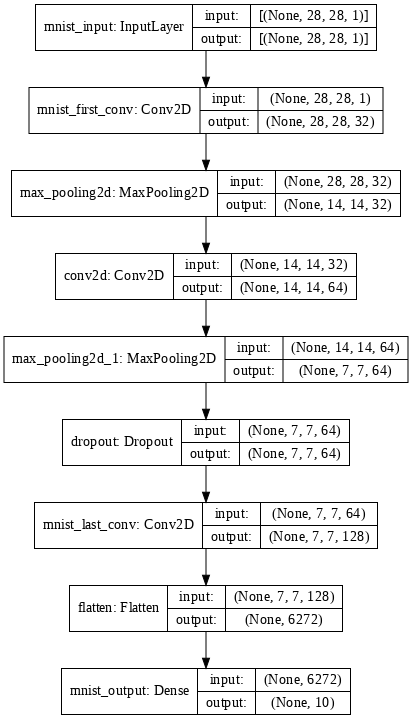

Epoch 1/10
375/375 [==============================] - 19s 7ms/step - loss: 0.2831 - accuracy: 0.9095 - val_loss: 0.0751 - val_accuracy: 0.9786
Epoch 2/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0768 - accuracy: 0.9758 - val_loss: 0.0472 - val_accuracy: 0.9869
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0549 - accuracy: 0.9826 - val_loss: 0.0382 - val_accuracy: 0.9887
Epoch 4/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0444 - accuracy: 0.9854 - val_loss: 0.0383 - val_accuracy: 0.9893
Epoch 5/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0386 - accuracy: 0.9875 - val_loss: 0.0356 - val_accuracy: 0.9891
Epoch 6/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0333 - accuracy: 0.9893 - val_loss: 0.0315 - val_accuracy: 0.9908
Epoch 7/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0304 - accuracy: 0.9903 - val_loss: 0.0336 - val_accuracy: 0.9910
Epoch

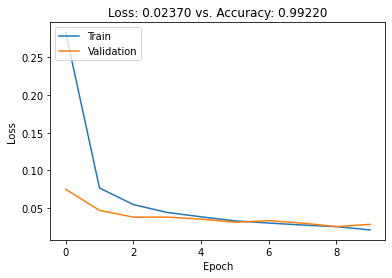

In [101]:
# A proof of concept CNN architecture trained over the MNIST dataset

mnist_num_classes = 10
mnist_shape = (28, 28)
mnist_train, mnist_test = keras.datasets.mnist.load_data()
mnist_train, mnist_test = format_dataset(mnist_num_classes, mnist_train, mnist_test)

model_mnist = keras.Sequential([
      keras.Input(shape=(*mnist_shape, 1), name="mnist_input"),
      layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv"),
      layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
      layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      layers.Dropout(0.5),
      layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv"),
      layers.Flatten(),
      layers.Dense(mnist_num_classes, activation="softmax", name="mnist_output"),
  ]
)

model_mnist.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

# architecture layout
display(keras.utils.plot_model(model_mnist, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_mnist = model_mnist.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=10, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_mnist = model_mnist.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_mnist, history_mnist.history)

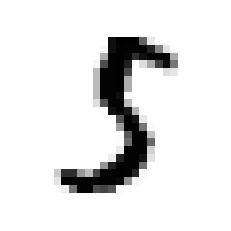

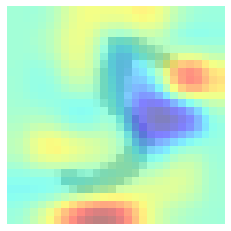

In [102]:
# predictin test
image, truth, prediction, _ = get_prediction(model_mnist, mnist_test)
cam, _, _, _ = grad_cam(image, model_mnist)

show_image(image, mnist_shape)
show_heatmap(image, cam, mnist_shape)

## Knowledge Domain Network

The Knowledge Domain Network (KDN) is the CNN architecture responsible for learning the 2D geometrical concepts as an intermediate explainable representation for justifying the classification of the problem domain.

In [103]:
# All Digit Decomposition Datasets variations
simple_dgd = ("simple", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset2_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "circle", "greater-than sign", "lower-than sign"])
edged_dgd = ("edged", "https://geo-cam.s3-eu-west-1.amazonaws.com/simpledataset3_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "135° oriented line", "ellipse", "greater-than sign", "lower-than sign", "arrow-up sign", "arrow-down sign"])
rounded_dgd = ("rounded", "https://geo-cam.s3.eu-west-1.amazonaws.com/rounddataset2_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "135° oriented line", "ellipse", "left-opened semicircle", "right-opened semicircle", "bottom-opened semicircle", "top-opened semicircle"])
moon_dgd = ("moon", "https://geo-cam.s3-eu-west-1.amazonaws.com/disambiguationdataset1_dataset.npz", ["vertical line", "horizontal line", "45° oriented line", "135° oriented line", "ellipse", "semi-circle"])

# dataset assignment
dataset = simple_dgd
# dataset = edged_dgd
# dataset = rounded_dgd
# dataset = moon_dgd

dataset_name = dataset[0]
dataset_labels = dataset[2]
dataset_num_classes = len(dataset_labels)

# download 
dataset_path = download_file(dataset[0], dataset[1])

# loading the dataset
geo_train, geo_test = load_npz_dataset(dataset_path)
geo_train, geo_test = format_dataset(len(dataset_labels), geo_train, geo_test)

18849792/18841002 [==============================] - 2s 0us/step
(28, 28)
4
x_train shape: (4200, 28, 28, 1)
4200 train samples
1800 test samples


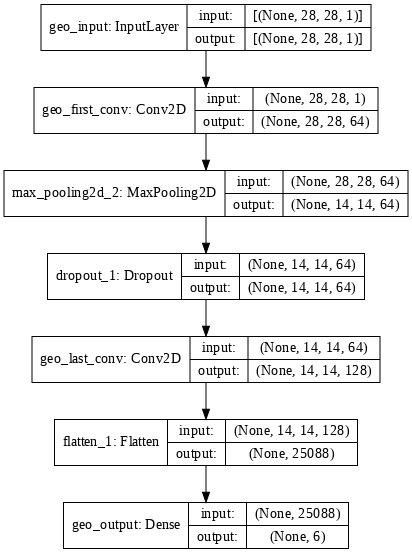

Epoch 1/10
25/25 [==============================] - 1s 20ms/step - loss: 1.2241 - accuracy: 0.5384 - val_loss: 0.6363 - val_accuracy: 0.7705
Epoch 2/10
25/25 [==============================] - 0s 11ms/step - loss: 0.3473 - accuracy: 0.8927 - val_loss: 0.1582 - val_accuracy: 0.9514
Epoch 3/10
25/25 [==============================] - 0s 10ms/step - loss: 0.1000 - accuracy: 0.9721 - val_loss: 0.0706 - val_accuracy: 0.9800
Epoch 4/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0318 - accuracy: 0.9933 - val_loss: 0.0465 - val_accuracy: 0.9829
Epoch 5/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0172 - accuracy: 0.9962 - val_loss: 0.0267 - val_accuracy: 0.9914
Epoch 6/10
25/25 [==============================] - 0s 9ms/step - loss: 0.0114 - accuracy: 0.9971 - val_loss: 0.0252 - val_accuracy: 0.9952
Epoch 7/10
25/25 [==============================] - 0s 10ms/step - loss: 0.0183 - accuracy: 0.9949 - val_loss: 0.0541 - val_accuracy: 0.9810
Epoch 8/10
25/

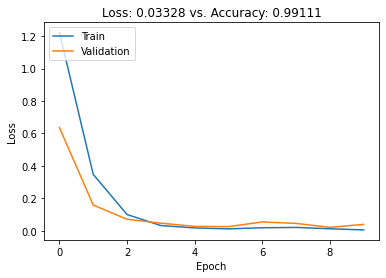

In [104]:
# KDN model
model_geo = keras.Sequential([
      keras.Input(shape=(*mnist_shape, 1), name="geo_input"),
      layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu", name="geo_first_conv"),
      layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2)),
      layers.Dropout(0.5),
      layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="geo_last_conv"),
      layers.Flatten(),
      layers.Dense(dataset_num_classes, activation="softmax", name="geo_output"),
  ]
)

opt = keras.optimizers.Adam(learning_rate=0.002)
model_geo.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# architecture layout
display(keras.utils.plot_model(model_geo, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geo = model_geo.fit(geo_train[0], geo_train[1], batch_size=128, epochs=10, validation_split=0.25)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_geo = model_geo.evaluate(geo_test[0], geo_test[1], verbose=0)
plot_model_score(score_geo, history_geo.history)

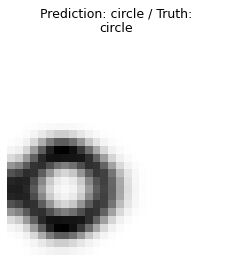

In [105]:
# prediction test
image, truth, prediction, _ = get_prediction(model_geo, geo_test)
show_prediction(image, truth, prediction, dataset_labels)

# Unified Model
<a name="um"/>

The Unified Model (UM) architectural concept. The KDN stacked over the PDN in a unified model with a multi-output with outputs used for the problem domain classification and CAMs from the knowledge domain.

## Base Unified Model
The Base Unified Model (BUM) architectural concept as the first model attempt as the base for our technique.

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
geo_input (InputLayer)          [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
geo_first_conv (Conv2D)         (None, 28, 28, 64)   640         geo_input[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)   0           geo_first_conv[1][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 64)   0           max_pooling2d_2[1][0]            
____________________________________________________________________________________________

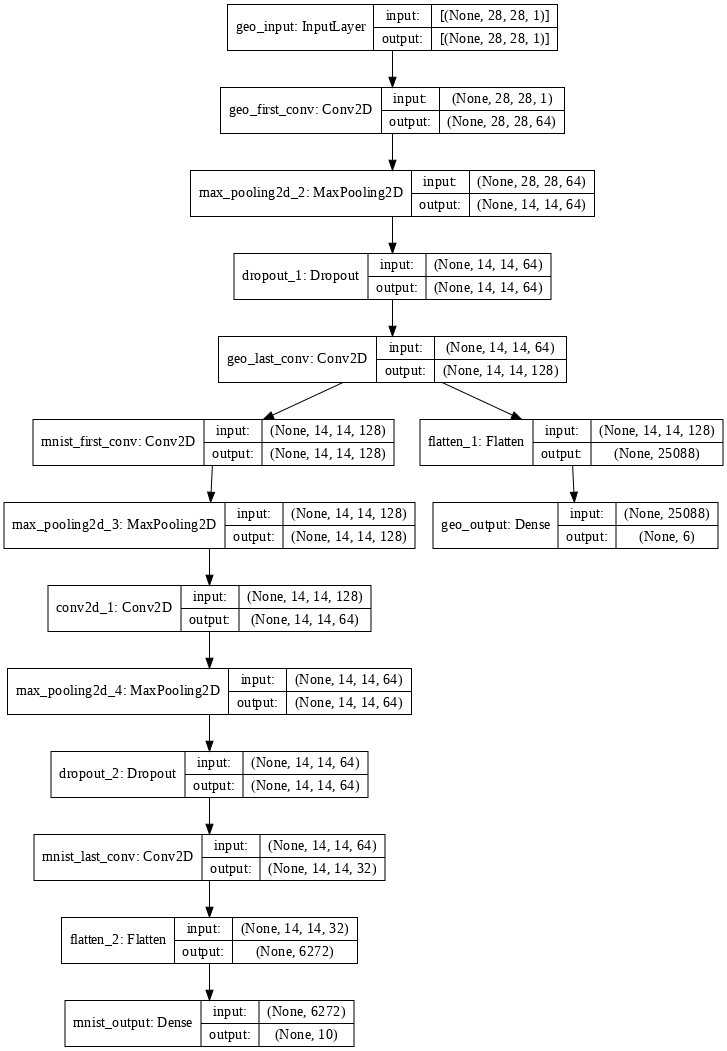

Epoch 1/15
375/375 [==============================] - 5s 13ms/step - loss: 0.2100 - accuracy: 0.9331 - val_loss: 0.0747 - val_accuracy: 0.9758
Epoch 2/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0820 - accuracy: 0.9744 - val_loss: 0.0551 - val_accuracy: 0.9836
Epoch 3/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0692 - accuracy: 0.9791 - val_loss: 0.0563 - val_accuracy: 0.9831
Epoch 4/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0592 - accuracy: 0.9819 - val_loss: 0.0503 - val_accuracy: 0.9839
Epoch 5/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0584 - accuracy: 0.9814 - val_loss: 0.0519 - val_accuracy: 0.9845
Epoch 6/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0545 - accuracy: 0.9828 - val_loss: 0.0458 - val_accuracy: 0.9865
Epoch 7/15
375/375 [==============================] - 4s 12ms/step - loss: 0.0508 - accuracy: 0.9843 - val_loss: 0.0485 - val_accuracy: 0.9852

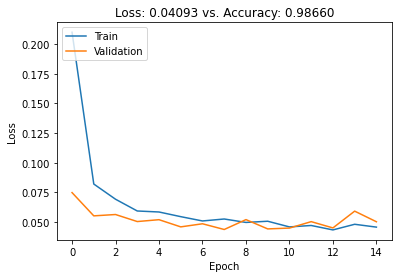

In [106]:
# loading models
mnist_model_copy = copy_model(model_mnist, True)
mnist_model_layers = get_cam_layers(mnist_model_copy)
geo_model_copy = copy_model(model_geo, False)
input = geo_model_copy.input
geo_last, geo2_last, last = input, None, None

# KDN section
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(geo_last)

# PDN section
mnist_first_cnn = last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv")(geo_last)
last = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(last)
last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(last)
last = layers.Dropout(0.5)(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv")(last)

# dense layers
last = layers.Flatten()(last)
mnist_last = last = layers.Dense(mnist_num_classes, activation="softmax", name="mnist_output")(last)

connection = geo_last

# KDN second output
for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(connection) if geo2_last is None else layer(geo2_last)

# final model
model_geo_fix = Model(inputs=input, outputs=mnist_last)
model_geo_fix_complete = Model(inputs=input, outputs=[mnist_last, geo2_last])

opt = keras.optimizers.Adam(learning_rate=0.002)
model_geo_fix.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# architectural summary
print(model_geo_fix_complete.summary())
display(keras.utils.plot_model(model_geo_fix_complete, show_shapes=True, dpi=72))

# train
start_time = time.perf_counter()
history_geocam = model_geo_fix.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_gcm = model_geo_fix.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_gcm, history_geocam.history)

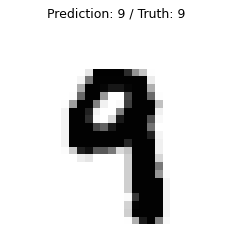

In [107]:
image, label, prediction, _ = get_prediction(model_geo_fix, mnist_test)
show_prediction(image, label, prediction)

## Extended Unified Model
The Extended Unified Model (XUM) network is the final attempt to reinforce the network's input to the PDN.

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
mnist_input (InputLayer)        [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
geo_first_conv (Conv2D)         (None, 28, 28, 64)   640         mnist_input[0][0]                
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 64)   0           geo_first_conv[1][0]             
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 14, 14, 64)   0           max_pooling2d_2[1][0]            
____________________________________________________________________________________________

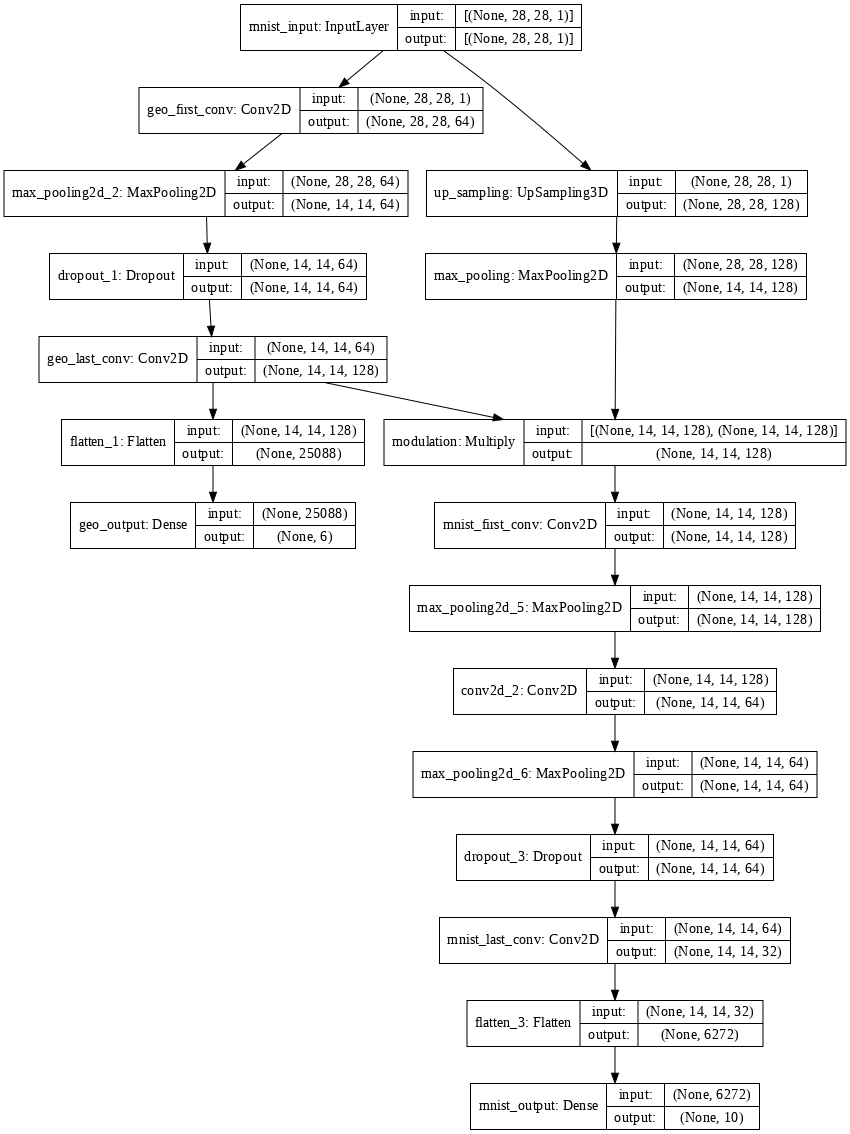

Epoch 1/15
375/375 [==============================] - 6s 14ms/step - loss: 0.2606 - accuracy: 0.9169 - val_loss: 0.0812 - val_accuracy: 0.9757
Epoch 2/15
375/375 [==============================] - 5s 14ms/step - loss: 0.1019 - accuracy: 0.9676 - val_loss: 0.0609 - val_accuracy: 0.9832
Epoch 3/15
375/375 [==============================] - 5s 14ms/step - loss: 0.0897 - accuracy: 0.9726 - val_loss: 0.0868 - val_accuracy: 0.9727
Epoch 4/15
375/375 [==============================] - 5s 14ms/step - loss: 0.0838 - accuracy: 0.9736 - val_loss: 0.0685 - val_accuracy: 0.9783
Epoch 5/15
375/375 [==============================] - 6s 15ms/step - loss: 0.0813 - accuracy: 0.9751 - val_loss: 0.0713 - val_accuracy: 0.9778
Epoch 6/15
375/375 [==============================] - 5s 14ms/step - loss: 0.0788 - accuracy: 0.9759 - val_loss: 0.0611 - val_accuracy: 0.9823
Epoch 7/15
375/375 [==============================] - 5s 13ms/step - loss: 0.0784 - accuracy: 0.9756 - val_loss: 0.0721 - val_accuracy: 0.9795

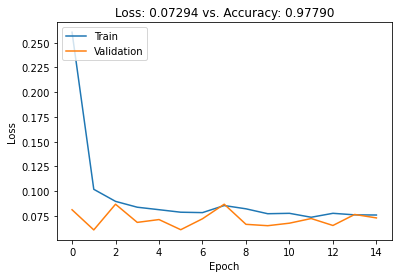

In [108]:
# loading models
mnist_model_copy = copy_model(model_mnist, True)
mnist_model_layers = get_cam_layers(mnist_model_copy)

geo_model_copy = copy_model(model_geo, False)
geo_model_layers = get_cam_layers(geo_model_copy)

mnist1_last, mnist2_last, geo1_last, geo2_last, last = None, None, None, None, None
input = mnist_model_copy.input

geo_last = input

# reinforced input
for layer in get_cam_layers(geo_model_copy)[0]:
  layer.trainable = False
  geo_last = layer(geo_last)

last = layers.UpSampling3D(size=(1, 1, 128), input_shape=(29, 28, 1), trainable=False, name="up_sampling")(input)
last = layers.MaxPooling2D(pool_size=(2, 2), strides=(2,2), trainable=False, name="max_pooling")(last)
last = layers.Multiply(trainable=False, name="modulation")([last, geo_last])

# PDN
mnist_first_cnn = last = layers.Conv2D(filters=128, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_first_conv")(last)
last = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(last)
last = layers.Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu")(last)
last = layers.MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same')(last)
last = layers.Dropout(0.5)(last)
last = layers.Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu", name="mnist_last_conv")(last)

# dense layer
last = layers.Flatten()(last)
mnist2_last = layers.Dense(mnist_num_classes, activation="softmax", name="mnist_output")(last)

# connection
connection = geo_last

# KDN
for layer in get_cam_layers(geo_model_copy)[1]:
  layer.trainable = False
  geo2_last = layer(connection) if geo2_last is None else layer(geo2_last)

# final model
model_geo_fix_extended = Model(inputs=input, outputs=mnist2_last)
model_geo_fix_extended_complete = Model(inputs=input, outputs=[geo2_last, mnist2_last])

# display
print(model_geo_fix_extended_complete.summary())
display(keras.utils.plot_model(model_geo_fix_extended_complete, show_shapes=True, dpi=72))

# compile
opt = keras.optimizers.Adam(learning_rate=0.004)
model_geo_fix_extended.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

# train
start_time = time.perf_counter()
history_geocam3 = model_geo_fix_extended.fit(mnist_train[0], mnist_train[1], batch_size=128, epochs=15, validation_split=0.2)
print("Training took: %.2f seconds" % (time.perf_counter() - start_time))

# evaluate
score_geocam2 = model_geo_fix_extended.evaluate(mnist_test[0], mnist_test[1], verbose=0)
plot_model_score(score_geocam2, history_geocam3.history)

# Knowledge Extraction Technique
<a name="ket"/>

The Knowledge Extraction Technique (KET) algorithm to etract the CAMs from the KDN from the UM and use as explanation domain for the PDN classification.

In [109]:
def get_experiment_cam_predictions(test_image, kdn, pdn,
                                   use_mask=False,
                                   threshold=0.8, 
                                   shape=mnist_shape):
  """The KET Algoritm
    """
  centers = dict()
  grid_pos = dict()
  geo_cam = dict()
  geo_cam_final = dict()
  cam_thresh = dict()

  geo_cam_maxes = []
  attenuated_geo_cam_maxes = []

  image_bb = get_boundingbox(test_image)

  # pd branch
  cam, _, predictions, _ = pdn['cam_method'](test_image, pdn['cnn_model'], -1, pdn['output_branch'])
  min, max, cam = normalize_cam(cam)
  pd_cam = np.copy(cam)

  # kd branch
  for category in range(kdn['num_classes']):
    cam, _, _, _  = kdn['cam_method'](test_image, kdn['cnn_model'], category, kdn['output_branch'])
    min, max, cam = normalize_cam(cam)

    geo_cam_maxes.append(max)
    geo_cam[category] = np.copy(cam)

  # attenuated cam
  for category in range(kdn['num_classes']):
    modulation = safe_divide(geo_cam_maxes[category], np.max(geo_cam_maxes), abs=False) # modulation
    cam = geo_cam[category]
    geo_cam[category] = np.copy(cam * modulation)

    if use_mask: # use main model as mask
      cam = cam - (cam * (1 - pd_cam))
    
    # print(f"min: {np.min(cam)}, max: {np.max(cam)}")
    geo_cam_final[category] = np.copy(cam * modulation)
    attenuated_geo_cam_maxes.append(np.max(geo_cam_final[category]))

  # threshorld and centers
  for category in range(kdn['num_classes']):
    cam = geo_cam_final[category]

    cam = np.uint8(np.copy(cam) * 255)
    cam = resize_image(cam, shape)
    cam = cv2.dilate(cam, None, iterations=1)

    cam_thresh[category] = cv2.threshold(cam, np.max(cam) * threshold, np.max(cam), cv2.THRESH_BINARY)[1] # + cv2.THRESH_OTSU
    contours = cv2.findContours(cam_thresh[category], cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

    centers[category] = []
    grid_pos[category] = set()

    for i in range(len(contours)):
      # center = cv2.minAreaRect(contours[i])[0]
      moments = cv2.moments(contours[i], True)
      if moments['m00'] > 0:
        center = (safe_divide(moments['m10'], moments['m00']), safe_divide(moments['m01'], moments['m00']))
        centers[category].append(center)
        grid_position = get_grid_position(center, shape, boundingbox=image_bb)
        grid_pos[category].add(grid_position)

  extra_infos = dict()
  extra_infos['order'] = np.flip(np.argsort(attenuated_geo_cam_maxes), 0)
  extra_infos['maxes'] = attenuated_geo_cam_maxes
  extra_infos['thresholds'] = cam_thresh
  extra_infos['geo_cams'] = geo_cam
  extra_infos['pd_cam'] = pd_cam
  extra_infos['final_cam'] = geo_cam_final
  extra_infos['predictions'] = np.argmax(predictions)
  extra_infos['centers'] = centers
  extra_infos['grid_pos'] = grid_pos
  extra_infos['bounding_box'] = image_bb

  return geo_cam_final, extra_infos

def get_experiment_cam_predictions_short(test_image, settings):
  return get_experiment_cam_predictions(test_image, settings['kdn'], settings['pdn'],
                                              use_mask=settings['use_mask'],
                                              threshold=settings['threshold'], 
                                              shape=settings['shape'])

# Tests
<a name="tests"/>

Section with the validation setup with tests (visualization) for the technique and with validation results.

## Setup

Parameter assignment for KET and the validation tests.

In [110]:
# Experiment Parameters
samples = 200
common_threshold = 0.7
min_prediction_value = 0
localization_check_enabled = True
nr_top_prediction_considered = 2
common_cam_method = grad_cam_m
use_mask = False

# Functional Models

## Base (PDN/KDN)
model_geocam = Model([model_geo.inputs], [get_layer(model_geo, "geo_last_conv").get_output_at(0), model_geo.output], name="model_geocam")
model_mnistcam = Model([model_mnist.inputs], [get_layer(model_mnist, "mnist_last_conv").get_output_at(0), model_mnist.output], name="model_geocam")

single_geo_settings = {'kdn':{'cnn_model':model_geocam, 'num_classes': dataset_num_classes, 'cam_method':common_cam_method, 'output_branch':0}, 
                       'pdn':{'cnn_model':model_mnistcam, 'num_classes': mnist_num_classes, 'cam_method':common_cam_method, 'output_branch':0},
                       'use_mask':use_mask, 'threshold':common_threshold, 'shape':mnist_shape}

## GEO-FIX
model_geocam_fix_mnist_first = Model([model_geo_fix_complete.inputs], 
                     [get_layer(model_geo_fix_complete, "mnist_first_conv").get_output_at(0), 
                      model_geo_fix_complete.output], name = "model_geocam_fix_mnist_first")

model_geocam_fix_mnist_last = Model([model_geo_fix_complete.inputs], 
                     [get_layer(model_geo_fix_complete, "mnist_last_conv").get_output_at(0), 
                      model_geo_fix_complete.output], name = "model_geocam_fix_mnist_last")

model_geocam_fix_geo_only = Model([model_geo_fix_complete.inputs], 
                     [get_layer(model_geo_fix_complete, "geo_last_conv").get_output_at(1), 
                      model_geo_fix_complete.output], name = "model_geocam_fix_geo_only")

geocam_fix_settings = {'kdn':{'cnn_model':model_geocam_fix_geo_only, 'num_classes': dataset_num_classes, 'cam_method':common_cam_method, 'output_branch':1}, 
                   'pdn':{'cnn_model':model_geocam_fix_mnist_last, 'num_classes': mnist_num_classes, 'cam_method':common_cam_method, 'output_branch':0},
                   'use_mask':use_mask, 'threshold':common_threshold, 'shape':mnist_shape}

## GEO-FIX Extended
model_geocam_fix_extended_mnist_first = Model([model_geo_fix_extended_complete.inputs], 
                     [get_layer(model_geo_fix_extended_complete, "mnist_first_conv").get_output_at(0), 
                      model_geo_fix_extended_complete.output], name = "model_geocam_fix_extended_mnist_first")

model_geocam_fix_extended_mnist_last = Model([model_geo_fix_extended_complete.inputs], 
                     [get_layer(model_geo_fix_extended_complete, "mnist_last_conv").get_output_at(0), 
                      model_geo_fix_extended_complete.output], name = "model_geocam_fix_extended_mnist_last")

model_geocam_fix_extended_only = Model([model_geo_fix_extended_complete.inputs], 
                     [get_layer(model_geo_fix_extended_complete, "geo_last_conv").get_output_at(1), 
                      model_geo_fix_extended_complete.output], name = "model_geocam_fix_extended_only")

geocam_fix_extended_settings = {'kdn':{'cnn_model':model_geocam_fix_extended_only, 'num_classes': dataset_num_classes, 'cam_method':common_cam_method, 'output_branch':0}, 
                          'pdn':{'cnn_model':model_geocam_fix_extended_mnist_last, 'num_classes': mnist_num_classes, 'cam_method':common_cam_method, 'output_branch':1},
                          'use_mask':use_mask, 'threshold':common_threshold, 'shape':mnist_shape}

# Chosen Architecture
experiment_settings = geocam_fix_settings

## Visualization

Helper methods for the debugging of the technique

### Adhoc Explanation

Example of multiple explanations with broken down steps.


METRICS: dataset=simple | cnn_model=model_geocam_fix_geo_only | cam: grad_cam_m | mask=False | mnist_layer:model_geocam_fix_mnist_last | top=2 | tresh=0.7 | samples=200 | minPred=0 | localization=True




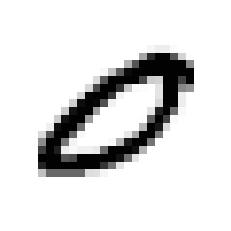

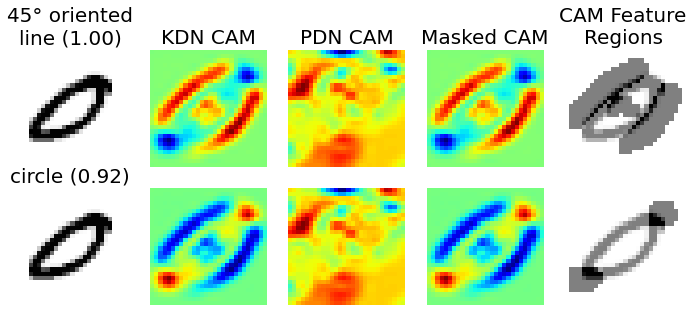

total order: [2 3 1 4 5 0]
6672 - The number 0 can be explained by having a(n) 45° oriented line on the center, and a(n) circle on the top-right and center.


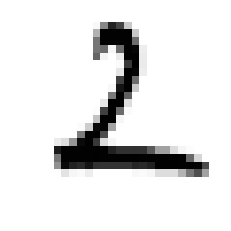

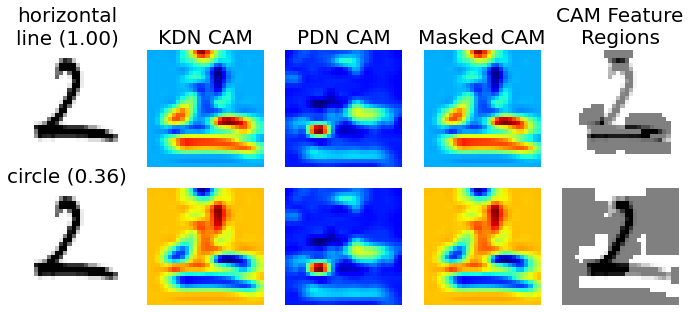

total order: [1 3 5 4 2 0]
4367 - The number 2 can be explained by having a(n) horizontal line on the top and top-left, and a(n) circle on the left and bottom.


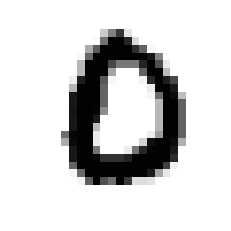

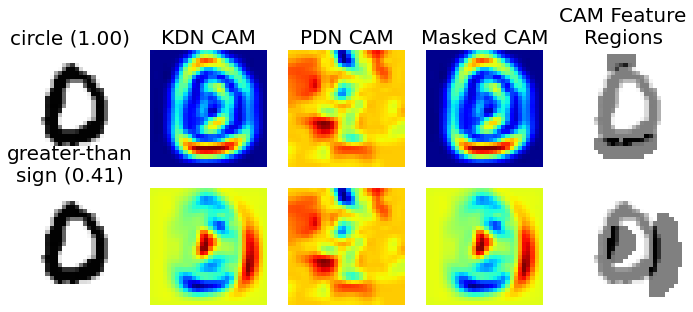

total order: [3 4 5 2 0 1]
1764 - The number 0 can be explained by having a(n) circle on the top-left and center, and a(n) greater-than sign on the left and center.


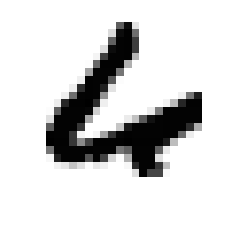

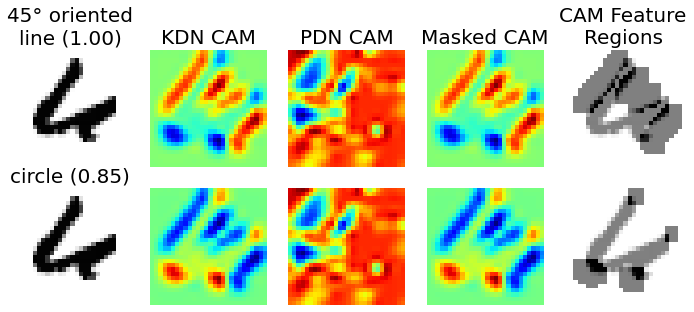

total order: [2 3 5 1 4 0]
625 - The number 6 can be explained by having a(n) 45° oriented line on the top and right, and a(n) circle on the top and top-left.


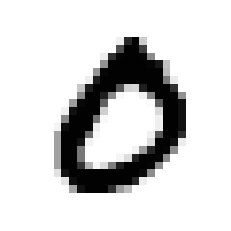

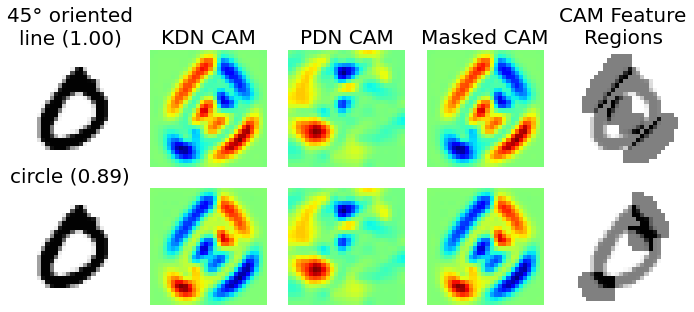

total order: [2 3 4 1 5 0]
6211 - The number 0 can be explained by having a(n) 45° oriented line on the top-left and center, and a(n) circle on the top-right and center.


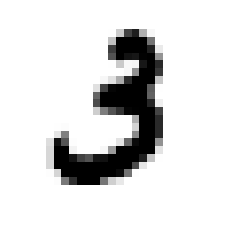

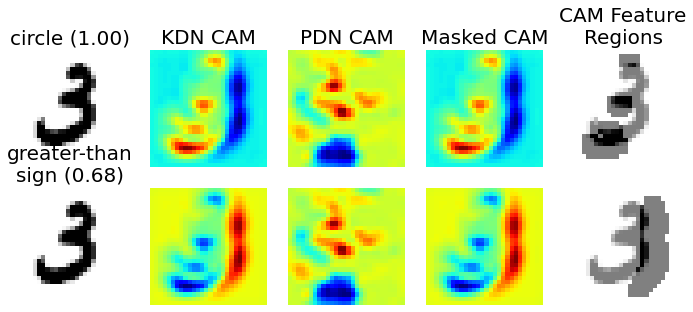

total order: [3 4 2 1 5 0]
8785 - The number 3 can be explained by having a(n) circle on the top, and a(n) greater-than sign on the right.


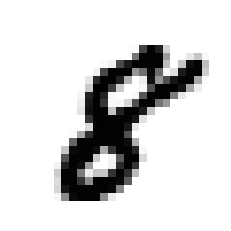

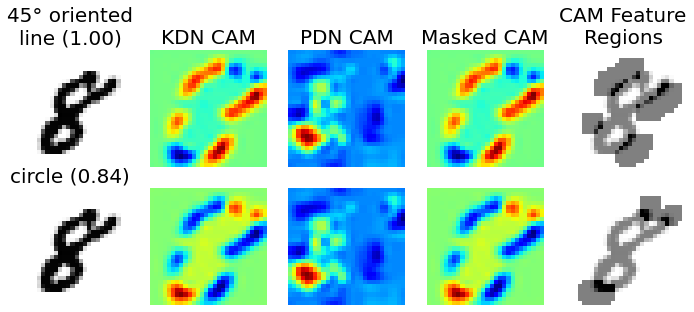

total order: [2 3 4 1 5 0]
9213 - The number 8 can be explained by having a(n) 45° oriented line on the top-left, and a(n) circle on the top-right and center.


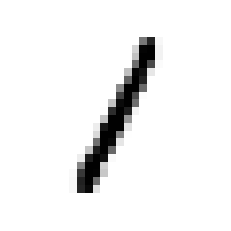

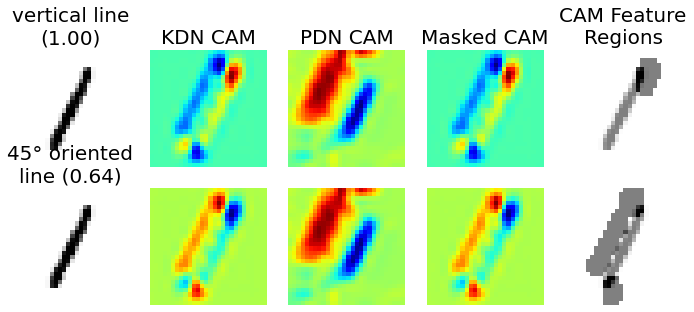

total order: [0 2 5 4 3 1]
5442 - The number 1 can be explained by having a(n) vertical line on the top-right, and a(n) 45° oriented line on the top-left and left.


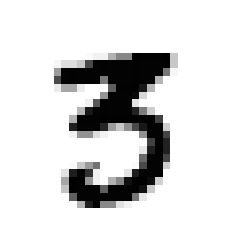

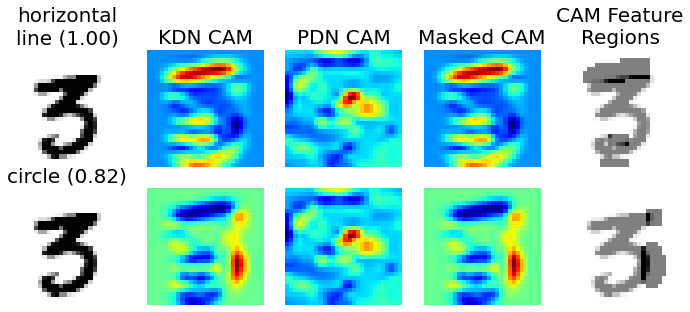

total order: [1 3 2 4 5 0]
5583 - The number 3 can be explained by having a(n) horizontal line on the top and center, and a(n) circle on the top-right.


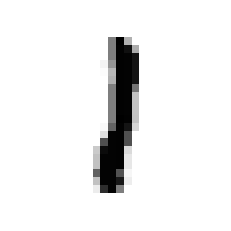

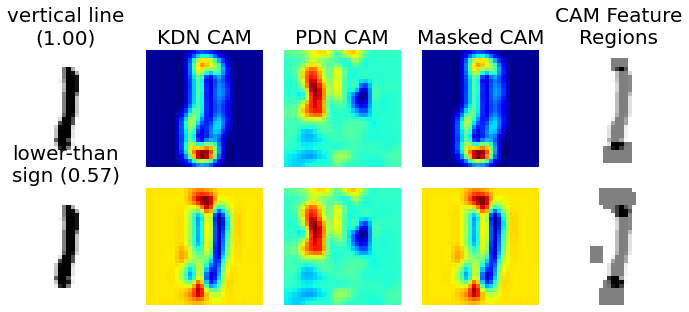

total order: [0 5 4 3 2 1]
850 - The number 1 can be explained by having a(n) vertical line on the top and center, and a(n) lower-than sign on the top.


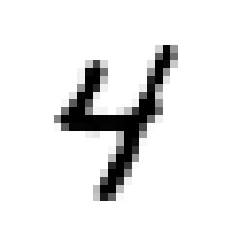

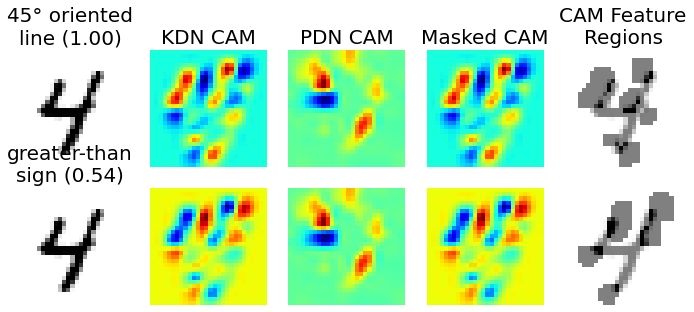

total order: [2 4 5 3 0 1]
2615 - The number 4 can be explained by having a(n) 45° oriented line on the top, and a(n) greater-than sign on the top-right.


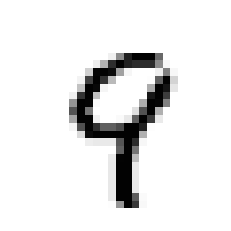

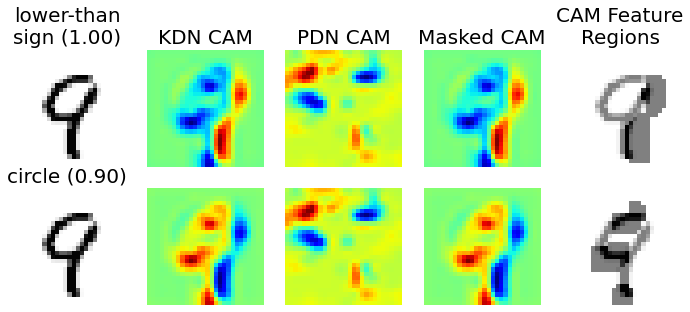

total order: [5 3 0 4 2 1]
2212 - The number 9 can be explained by having a(n) lower-than sign on the right, and a(n) circle on the top and top-left.


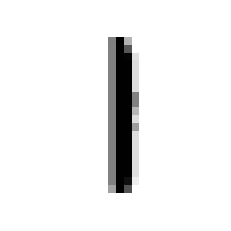

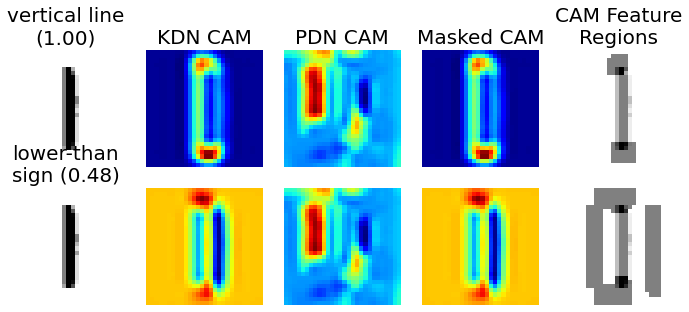

total order: [0 5 4 3 2 1]
5524 - The number 1 can be explained by having a(n) vertical line on the top-left and left, and a(n) lower-than sign on the left and center.


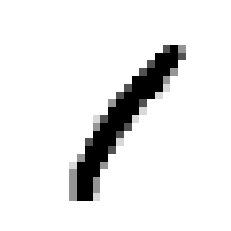

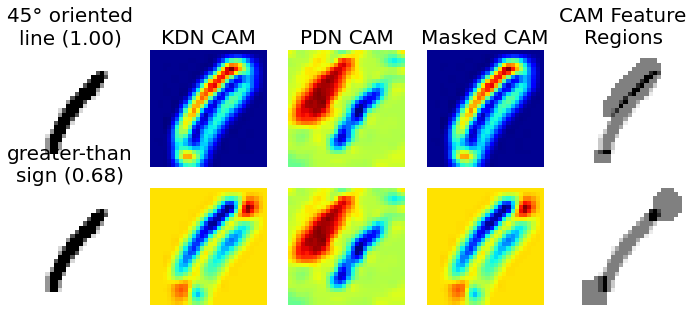

total order: [2 4 5 0 3 1]
9190 - The number 1 can be explained by having a(n) 45° oriented line on the top and left, and a(n) greater-than sign on the top-right and center.


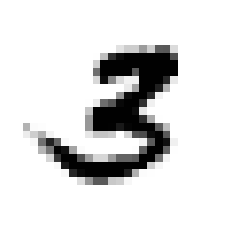

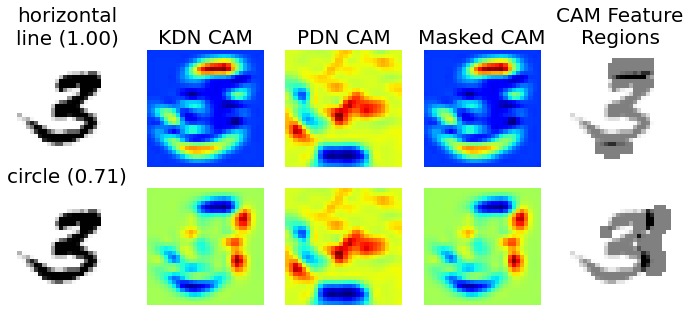

total order: [1 3 4 2 5 0]
5468 - The number 3 can be explained by having a(n) horizontal line on the top and center, and a(n) circle on the top and right.


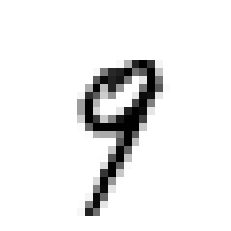

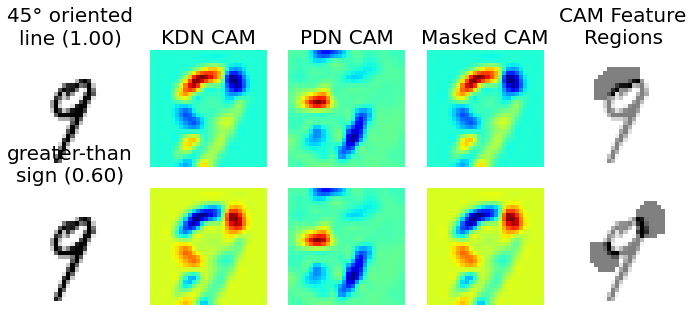

total order: [2 4 0 3 5 1]
4016 - The number 9 can be explained by having a(n) 45° oriented line on the top-left, and a(n) greater-than sign on the top-right and center.


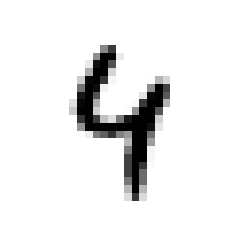

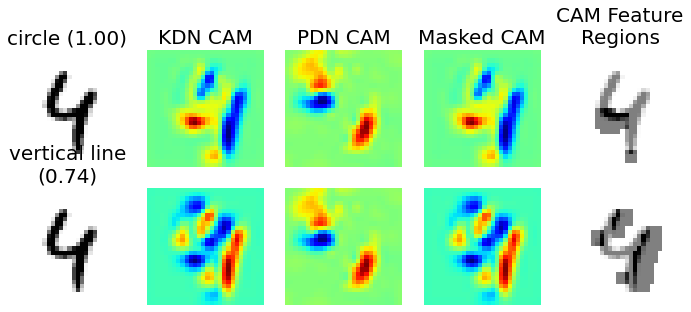

total order: [3 0 5 4 2 1]
2683 - The number 4 can be explained by having a(n) circle on the left and bottom, and a(n) vertical line on the top-left.


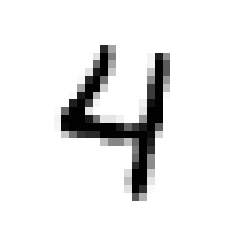

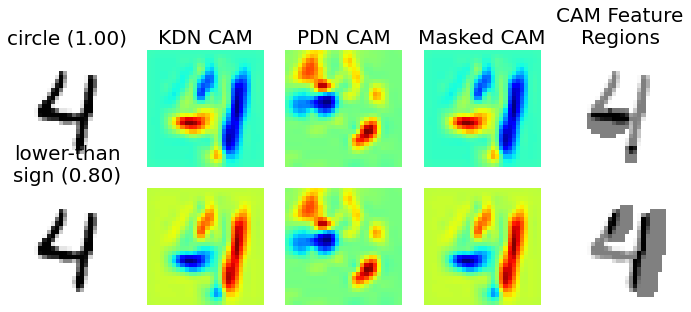

total order: [3 5 0 4 2 1]
27 - The number 4 can be explained by having a(n) circle on the left and bottom, and a(n) lower-than sign on the top and right.


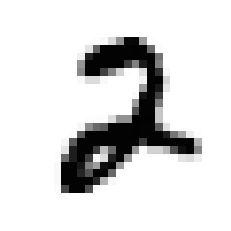

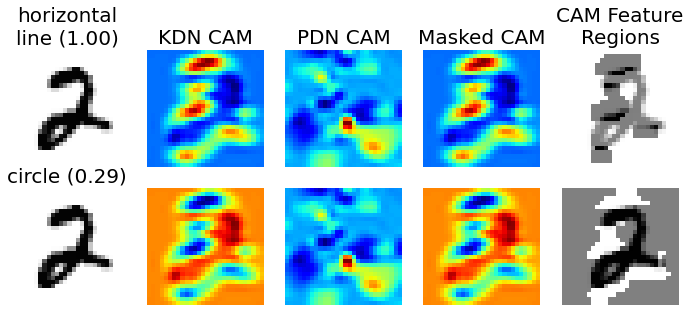

total order: [1 3 2 4 5 0]
7147 - The number 2 can be explained by having a(n) horizontal line on the left and center, and a(n) circle on the center.


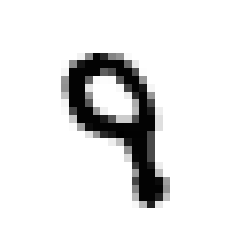

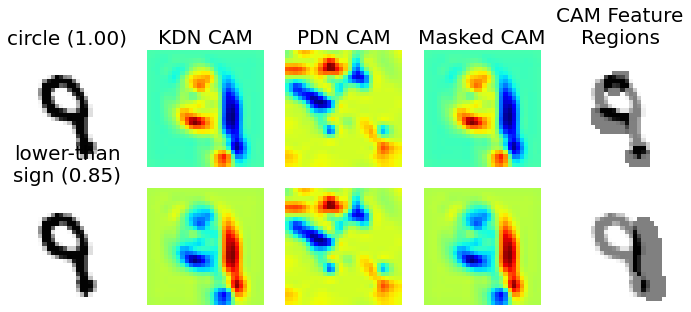

total order: [3 5 4 0 1 2]
1435 - The number 9 can be explained by having a(n) circle on the top and top-left, and a(n) lower-than sign on the right.


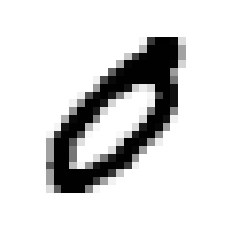

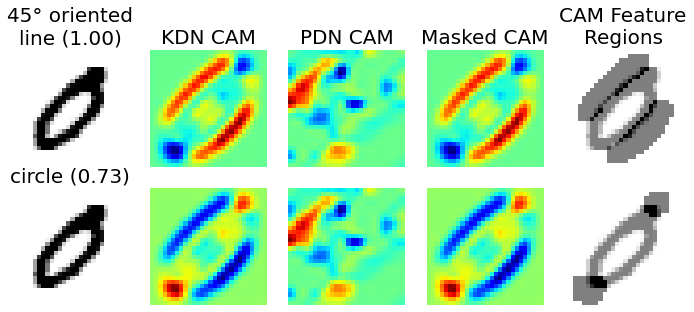

total order: [2 3 4 1 5 0]
9791 - The number 0 can be explained by having a(n) 45° oriented line on the top-left and center, and a(n) circle on the top-right and center.


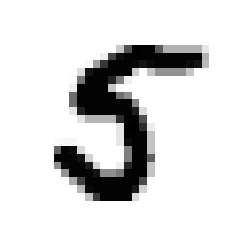

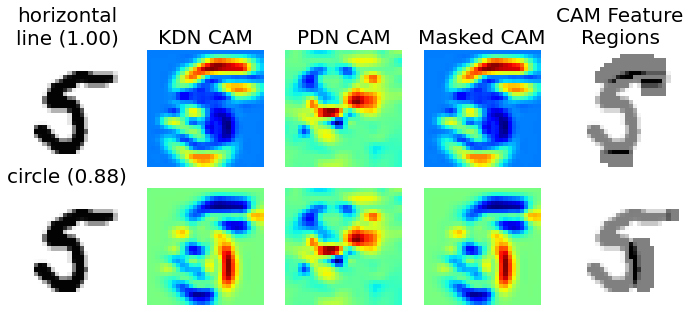

total order: [1 3 2 5 4 0]
6186 - The number 5 can be explained by having a(n) horizontal line on the top-right and center, and a(n) circle on the top-right.


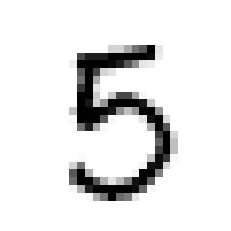

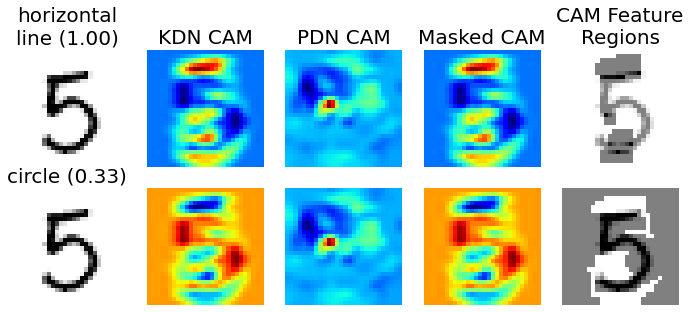

total order: [1 3 2 4 5 0]
1144 - The number 5 can be explained by having a(n) horizontal line on the top, and a(n) circle on the top.


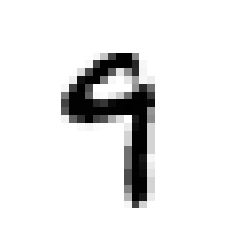

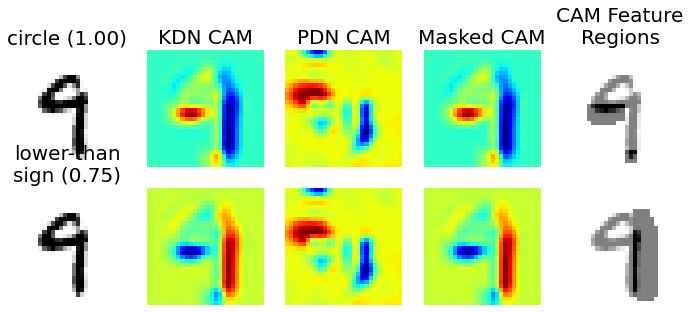

total order: [3 5 4 0 2 1]
108 - The number 9 can be explained by having a(n) circle on the left and bottom, and a(n) lower-than sign on the right.


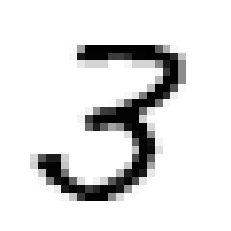

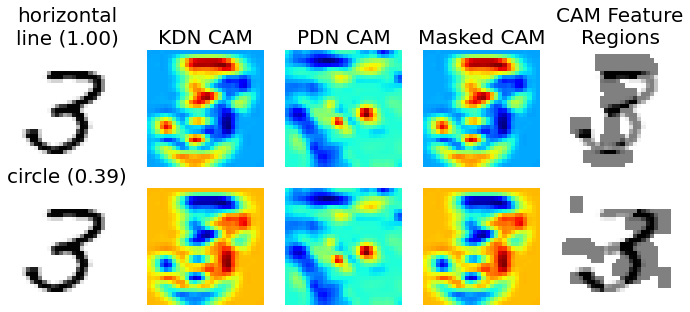

total order: [1 3 2 4 5 0]
5168 - The number 3 can be explained by having a(n) horizontal line on the top, and a(n) circle on the left and center.


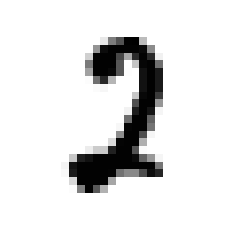

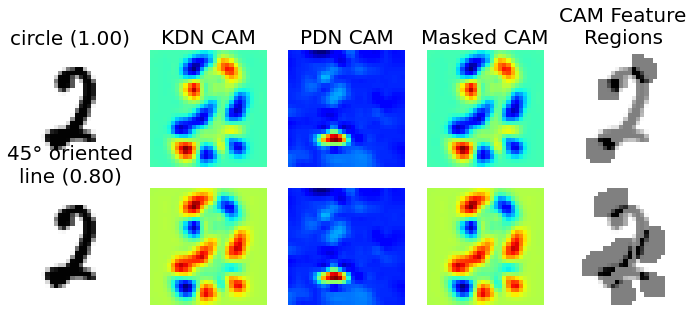

total order: [3 2 5 4 1 0]
7345 - The number 2 can be explained by having a(n) circle on the top-left, and a(n) 45° oriented line on the top-left and center.


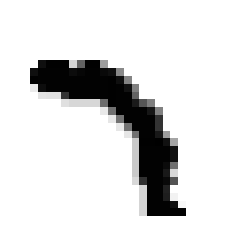

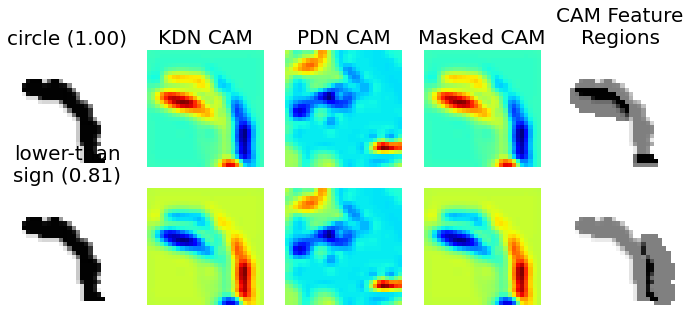

total order: [3 5 4 1 0 2]
1671 - The number 7 can be explained by having a(n) circle on the top-left and center, and a(n) lower-than sign on the right.


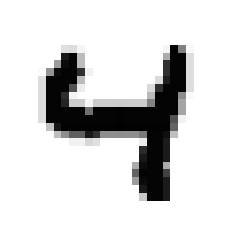

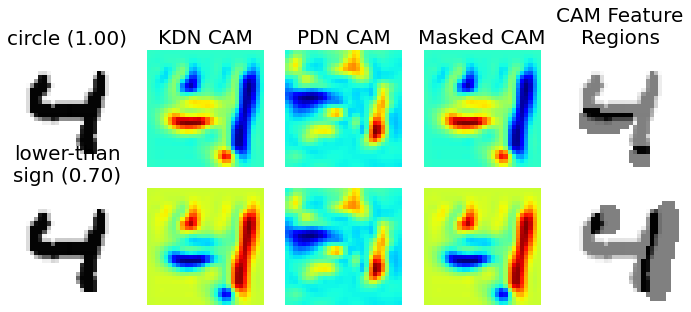

total order: [3 5 4 2 1 0]
719 - The number 4 can be explained by having a(n) circle on the left and bottom, and a(n) lower-than sign on the top-left and center.


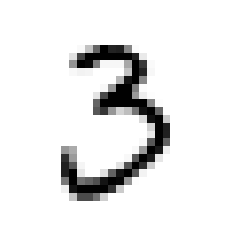

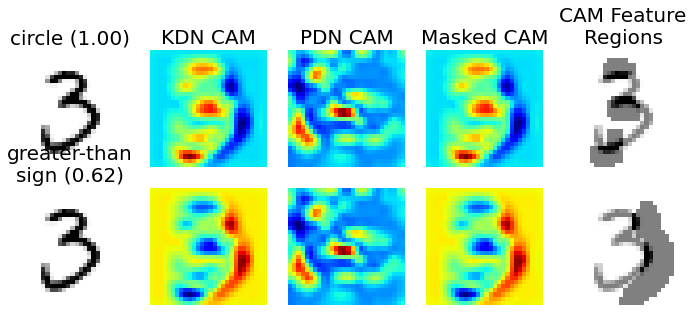

total order: [3 4 1 2 5 0]
1519 - The number 3 can be explained by having a(n) circle on the top, and a(n) greater-than sign on the right.


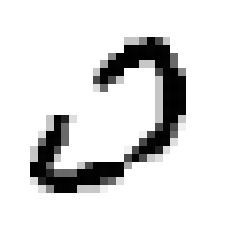

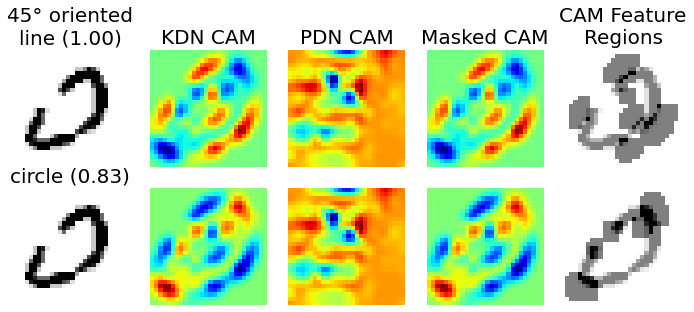

total order: [2 3 1 4 5 0]
2329 - The number 0 can be explained by having a(n) 45° oriented line on the top and top-left, and a(n) circle on the top-right and left.


In [111]:
sample_id = -1

print(f"\nMETRICS: dataset={dataset_name} | cnn_model={experiment_settings['kdn']['cnn_model'].name} | cam: {common_cam_method.__name__} | mask={experiment_settings['use_mask']} | mnist_layer:{experiment_settings['pdn']['cnn_model'].name} | top={nr_top_prediction_considered} | tresh={common_threshold} | samples={samples} | minPred={min_prediction_value} | localization={localization_check_enabled}\n\n")

for i in range(30):
  test_image, test_label, test_idx = get_sample(mnist_test, sample_id)

  cam, extras = get_experiment_cam_predictions_short(test_image, experiment_settings)

  first_pred = extras['order'][0]
  sec_pred = extras['order'][1]

  show_image(test_image, size=mnist_shape)
  
  show_image_in_grid(np.array([
                                [
                                {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[first_pred]} ({extras['maxes'][first_pred]:.2f})"},
                                {'img': extras['geo_cams'][first_pred], 'cmap':'jet', 'title':'KDN CAM'},
                                {'img': extras['pd_cam'], 'cmap':'jet', 'title':'PDN CAM', 'alpha': 0 if experiment_settings['use_mask'] else 1},
                                {'img': extras['final_cam'][first_pred], 'cmap':'jet', 'title':'Masked CAM'},
                                {'img': test_image, 'stacked': [{'img': extras['thresholds'][first_pred]}], 'title':"CAM Feature Regions"},
                                ],[
                                {'img': test_image, 'cmap':'Greys', 'title':f"{dataset_labels[sec_pred]} ({extras['maxes'][sec_pred]:.2f})"},
                                {'img': extras['geo_cams'][sec_pred], 'cmap':'jet'},
                                {'img': extras['pd_cam'], 'cmap':'jet', 'alpha': 0 if experiment_settings['use_mask'] else 1},
                                {'img': extras['final_cam'][sec_pred], 'cmap':'jet'},
                                {'img': test_image, 'stacked': [{'img': extras['thresholds'][sec_pred]}]},
                                ]
                                ]), mnist_shape, figsize=(12, 12), fontsize=20)

  print(f"total order: {extras['order']}")

  explanation = ""

  for idx in range(2):
    order = extras['order'][idx]
    verbose_key = dataset_labels[order]

    grid_positions = extras['grid_pos'][order]

    if len(grid_positions) > 0:
      if len(explanation) > 0:
        explanation += ", and"
      explanation += f" a(n) {verbose_key} on the "

      explanation += get_verbose_unified_positions(grid_positions)

  print(f"{test_idx} - The number {extras['predictions']} can be explained by having{explanation}.")

### CAMs from the UM

Visual break down from the CAMs in a KET run.


METRICS: dataset=simple | cnn_model=model_geocam_fix_geo_only | cam: grad_cam_m | mask=False | mnist_layer:model_geocam_fix_mnist_last | top=2 | tresh=0.7 | samples=200 | minPred=0 | localization=True




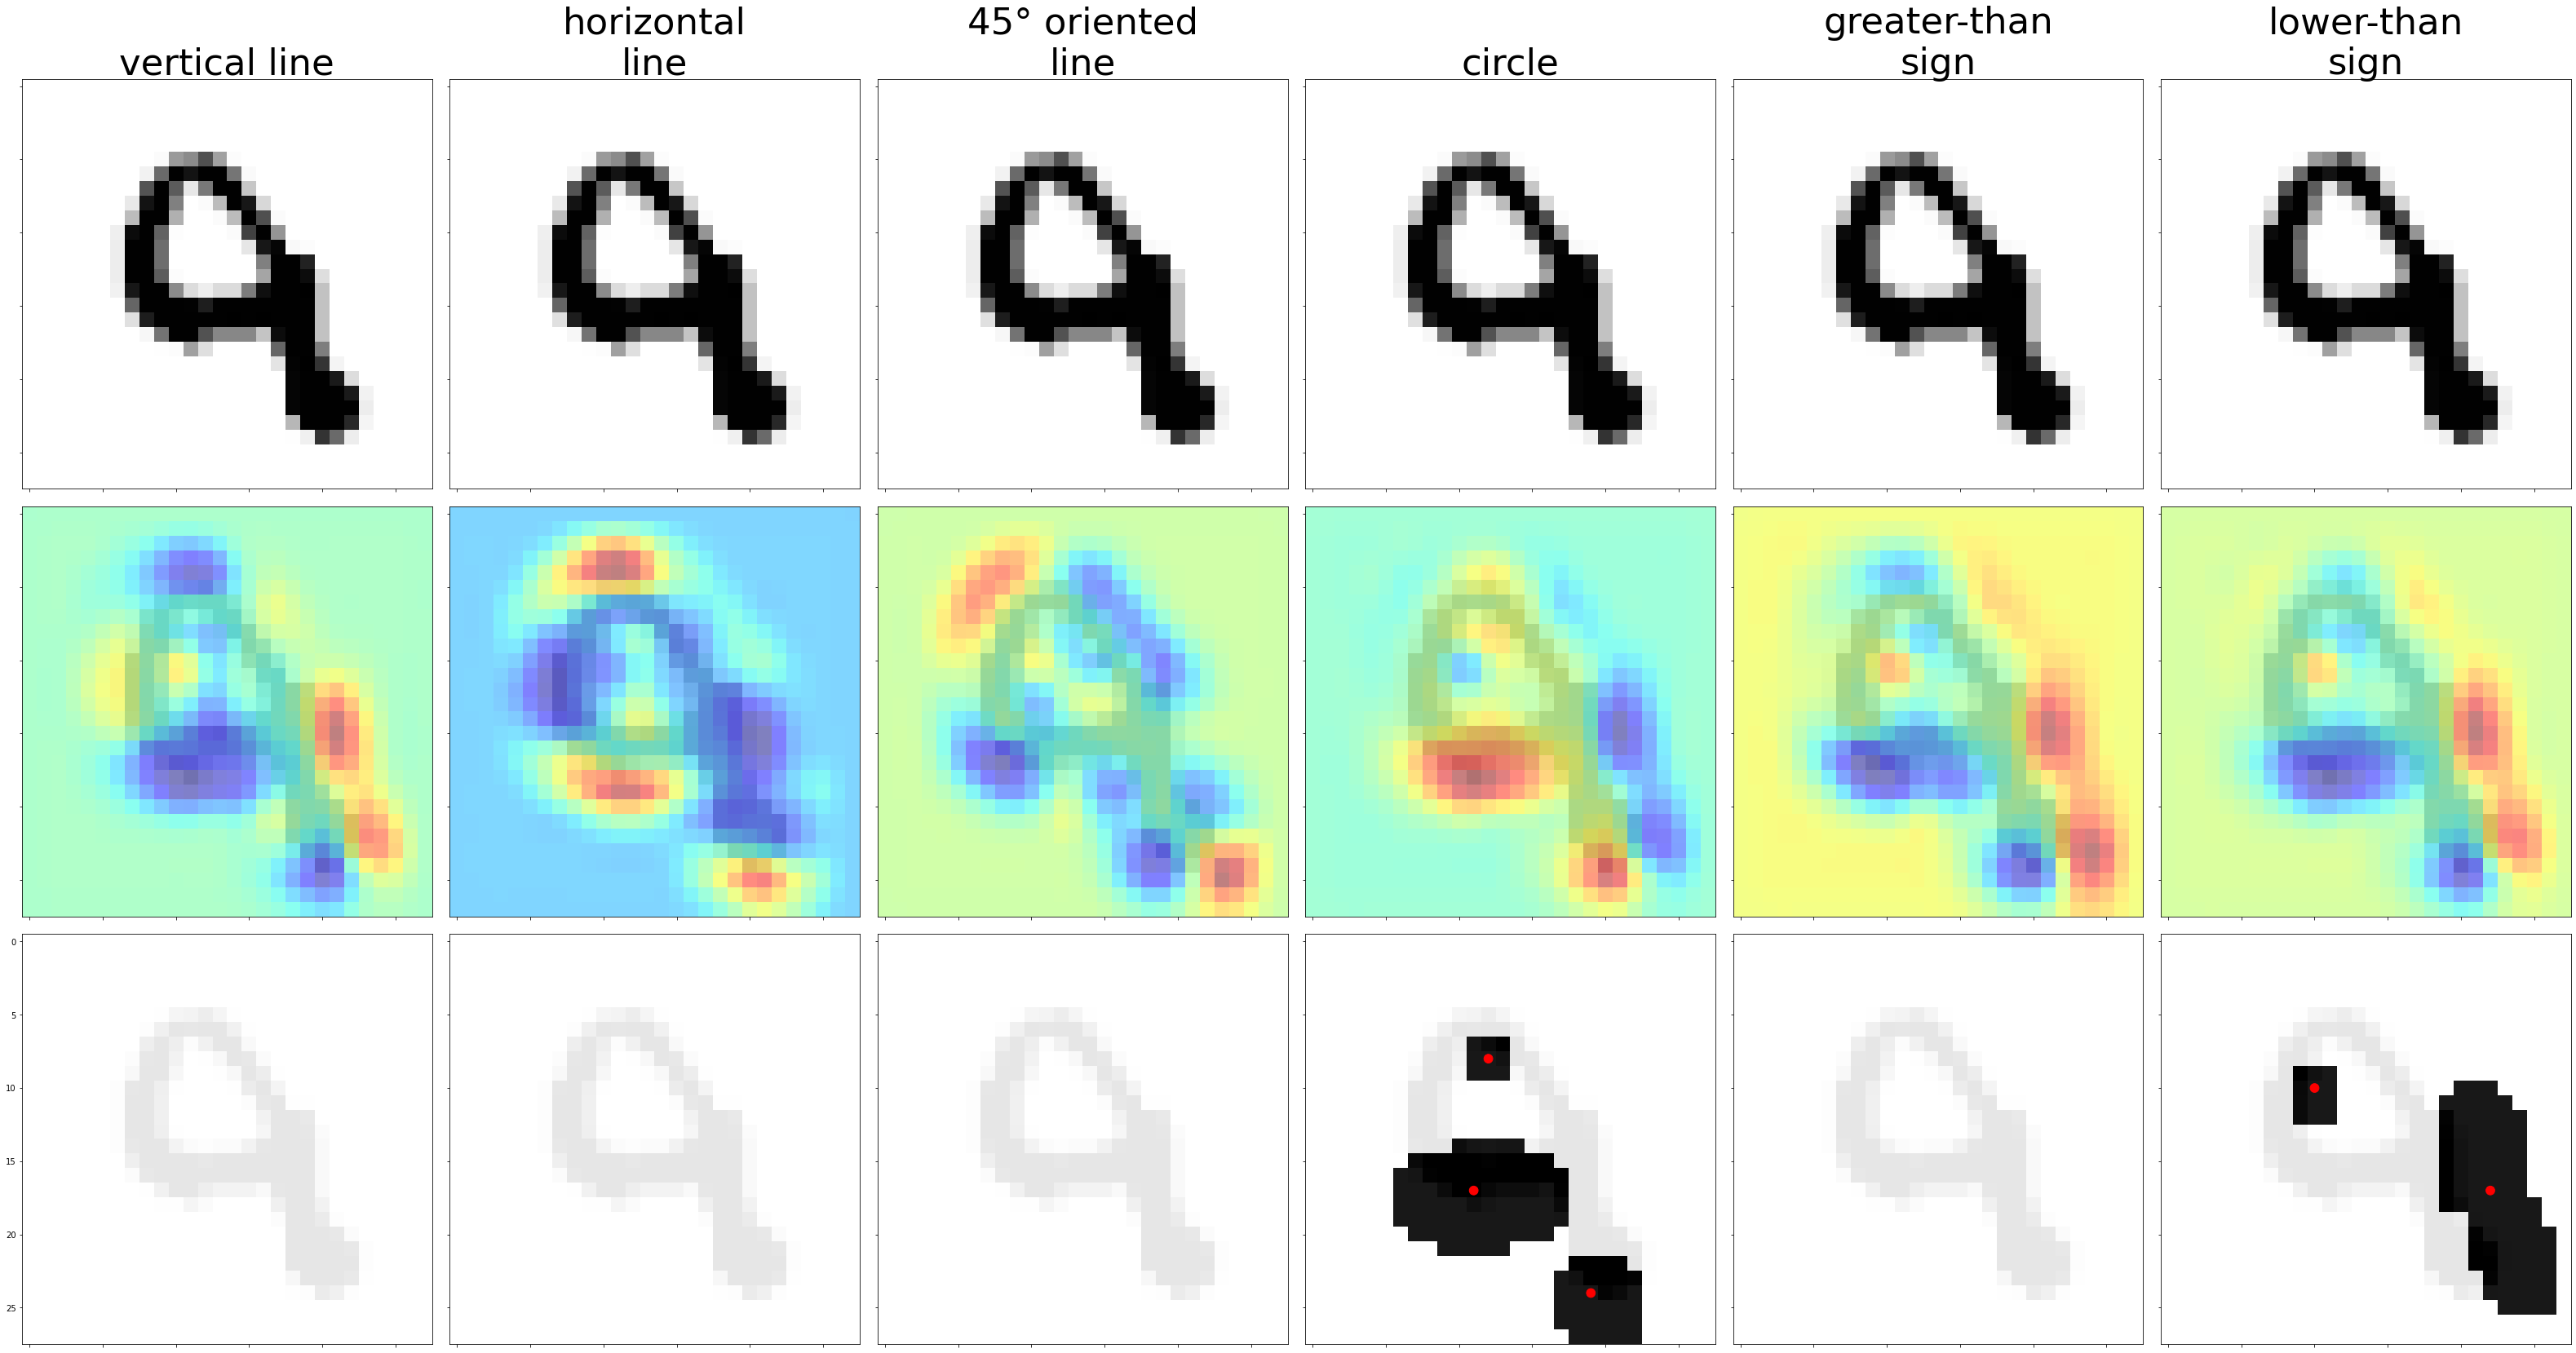

In [112]:
warnings.simplefilter('ignore', UserWarning)

show_titles = True
show_geo_cam = True
show_mnist_cam = False
show_final_cam = False

# prediction based on conv output
test_image, test_label, test_idx = get_sample(mnist_test)

print(f"\nMETRICS: dataset={dataset_name} | cnn_model={experiment_settings['kdn']['cnn_model'].name} | cam: {common_cam_method.__name__} | mask={experiment_settings['use_mask']} | mnist_layer:{experiment_settings['pdn']['cnn_model'].name} | top={nr_top_prediction_considered} | tresh={common_threshold} | samples={samples} | minPred={min_prediction_value} | localization={localization_check_enabled}\n\n")

# start plotting
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(2 + int(show_geo_cam) + int(show_mnist_cam) + int(show_final_cam), len(dataset_labels)), axes_pad=0.3, label_mode="1")

# images
for category in range(len(dataset_labels)):
  title = f"{dataset_labels[category]}"
  show_image(test_image, mnist_shape, title if show_titles else "", ax=grid[image_idx], fontsize=45)
  image_idx += 1

# geocam
cam_activations, cam_extra = get_experiment_cam_predictions_short(test_image, experiment_settings)

# geo cam
if show_geo_cam:
  for category in range(len(dataset_labels)):
    cam = cam_extra['geo_cams'][category]
    title = f"GEO CAM - max_cam: {np.max(cam)}"
    show_heatmap(test_image, cam, mnist_shape, True, "", ax=grid[image_idx])
    image_idx += 1

# minist cam
cam = cam_extra['pd_cam']
if show_mnist_cam:
  for category in range(len(dataset_labels)):
    title = f"MNIST CAM - max_cam: {np.max(cam)}"
    show_heatmap(test_image, cam, mnist_shape, True, "", ax=grid[image_idx])
    image_idx += 1

# geocam cam
if show_final_cam:
  for category in range(len(dataset_labels)):
    cam = cam_extra['final_cam'][category]
    title = f"GEO CAM - max_cam: {np.max(cam)}"
    show_heatmap(test_image, cam, mnist_shape, True, "", ax=grid[image_idx])
    image_idx += 1

# geocam areas
for category in range(len(dataset_labels)):
  camt = cam_extra['thresholds'][category]
  camp = cam_extra['centers'][category]
  bb = cam_extra['bounding_box']

  grid[image_idx].imshow(camt, cmap='Greys')
  grid[image_idx].imshow(resize_image(test_image, mnist_shape), cmap='Greys', alpha=0.1)
  # grid[image_idx].add_patch(plt.Rectangle((bb[0], bb[1]), bb[2], bb[3], angle=0, color='white', fill=None, lw=2, linestyle='dashed'))
  
  for center_idx in range(len(camp)):
    camp_center = camp[center_idx]
    grid[image_idx].add_patch(plt.Circle(camp_center, 0.3, color='r'))

  image_idx += 1

plt.show()

## Validation Methods

Region for the custom created validation techniques:
* Category Metric
* Category Description
* Category Representation

### Category Metric

The Category Metric and the test run resulting in aggregated data.

In [113]:
def category_metrics():
  """Helper method to return the aggregated results from the metric
    """
  vertical = 0
  horizontal = 1 
  fwd_diagonal = 2
  ellipse = 3 if dataset_name == "simple" else 4
  greather_than = 4 if dataset_name == "simple" else 5
  lower_than = 5 if dataset_name == "simple" else (5 if dataset_name == "moon" else 6)

  digits_descriptions = [None] * 10
  digits_descriptions[0] = [{'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 1), (1, 2)]}]
  digits_descriptions[1] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]}]
  digits_descriptions[2] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
                            {'desc': dataset_labels[horizontal], 'pos':[(1, 0), (1, 2)]}, 
                            {'desc': dataset_labels[greather_than], 'pos':[(2, 0)]}]
  digits_descriptions[3] = [{'desc': dataset_labels[greather_than], 'pos':[(1, 0), (1, 2)]}, 
                            {'desc': dataset_labels[lower_than], 'pos':[(1, 1)]}]
  digits_descriptions[4] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2), (0, 0), (0, 1)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2), (0, 1), (0, 0)]},
                            {'desc': dataset_labels[horizontal], 'pos':[(1, 1)]}]
  digits_descriptions[5] = [{'desc': dataset_labels[vertical], 'pos':[(0, 1)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(0, 1)]}, 
                            {'desc': dataset_labels[greather_than], 'pos':[(1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[horizontal], 'pos':[(1, 0), (1, 1)]}]
  digits_descriptions[6] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
                            {'desc': dataset_labels[ellipse], 'pos':[(1, 1), (1, 2)]}]
  digits_descriptions[7] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
                            {'desc': dataset_labels[horizontal], 'pos':[(0, 0), (1, 0), (2, 0)]}]
  digits_descriptions[8] = [{'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 2)]}]
  digits_descriptions[9] = [{'desc': dataset_labels[vertical], 'pos':[(1, 0), (1, 1), (1, 2)]}, 
                            {'desc': dataset_labels[fwd_diagonal], 'pos':[(1, 0), (1, 1), (1, 2)]},
                            {'desc': dataset_labels[ellipse], 'pos':[(1, 0), (1, 1)]}]

  descriptions = dict()
  metrics, y_true, y_pred = dict(), dict(), dict()
  with tqdm(total=(samples * mnist_num_classes), position=0, leave=True) as pbar:
    for mnist_category in range(mnist_num_classes):
      metrics[mnist_category] = dict()
      descriptions[mnist_category] = dict()

      decomposed_category = np.zeros(shape=(mnist_num_classes))
      decomposed_category[mnist_category] = 1
      
      y_true[mnist_category] = np.ones(shape=(samples))
      y_pred[mnist_category] = np.zeros(shape=(samples))

      for geo_class in range(dataset_num_classes):
        descriptions[mnist_category][geo_class] = []

      for i in range(samples):
        validation_idx = random.choice(np.argwhere(np.equal(mnist_test[1], decomposed_category).all(1)))[0]
        test_image = mnist_test[0][validation_idx]

        # geo cam
        cam, extras = get_experiment_cam_predictions_short(test_image, experiment_settings)

        # prediction
        for p in range(nr_top_prediction_considered):
          geo_id = extras['order'][p]

          for grid_position in extras['grid_pos'][geo_id]:
            descriptions[mnist_category][geo_id].append(grid_position)
            
          if y_pred[mnist_category][i] == 1 or extras['maxes'][geo_id] < min_prediction_value:
            continue
          
          results = list(filter(lambda description: description['desc'] == dataset_labels[geo_id], digits_descriptions[mnist_category]))
          
          if localization_check_enabled:
            for r in results:
              possible_positions = r['pos']
              positions_found = extras['grid_pos'][geo_id]
              matches = len(set(positions_found) & set(positions_found)) > 0
              if matches:
                y_pred[mnist_category][i] = 1
                break
          elif len(results) > 0:
            y_pred[mnist_category][i] = 1

        pbar.update()

      # metrics per category
      metrics[mnist_category]['accuracy']   = accuracy_score(y_true[mnist_category], y_pred[mnist_category])

  # out
  print(f"\n\nMETRICS: dataset={dataset_name} | cnn_model={experiment_settings['kdn']['cnn_model'].name} | cam: {common_cam_method.__name__} | mask={experiment_settings['use_mask']} | mnist_layer:{experiment_settings['pdn']['cnn_model'].name} | top={nr_top_prediction_considered} | tresh={common_threshold} | samples={samples} | minPred={min_prediction_value} | localization={localization_check_enabled}")

  # macro metrics
  print("\nMacro:")
  macro_metrics = dict()
  for cat in metrics:
    for key in metrics[cat]:
      macro_metrics[key] = macro_metrics.get(key) or []
      macro_metrics[key].append(metrics[cat][key])
    
  for key in macro_metrics:
    print(f"- {key}: {np.average(macro_metrics[key]):.2f}")

  # micro metrics
  print("\nMicro:")
  for cat in metrics:
    all_metrics = ', '.join([f"{key}:{np.average(metrics[cat][key]):.2f}" for key in metrics[cat]])
    print(f"- {cat}: {all_metrics}")

  return descriptions

descriptions = category_metrics()

100%|██████████| 2000/2000 [01:56<00:00, 17.16it/s]



METRICS: dataset=simple | cnn_model=model_geocam_fix_geo_only | cam: grad_cam_m | mask=False | mnist_layer:model_geocam_fix_mnist_last | top=2 | tresh=0.7 | samples=200 | minPred=0 | localization=True

Macro:
- accuracy: 0.85

Micro:
- 0: accuracy:0.98
- 1: accuracy:1.00
- 2: accuracy:0.96
- 3: accuracy:0.33
- 4: accuracy:0.67
- 5: accuracy:0.96
- 6: accuracy:1.00
- 7: accuracy:0.68
- 8: accuracy:0.94
- 9: accuracy:0.99


### Category Description

Generation of the Category Description values.

In [114]:
# textual values
for category in range(mnist_num_classes):
  print(f"\n{category}")

  for description_position in descriptions[category]:
    verbose_positions = set()
    grid_position = descriptions[category][description_position]
    aggregated_amount = len(grid_position)
    
    for k in grid_position:
      verbose_positions.add(get_verbose_grid_position(*k))
    
    print(f"└ {dataset_labels[description_position]}: {aggregated_amount} = {verbose_positions}")


0
└ vertical line: 53 = {('left', 'left'), ('bottom', 'right'), ('center', 'center'), ('right', 'right'), ('top', 'left')}
└ horizontal line: 96 = {('left', 'left'), ('bottom', 'bottom'), ('bottom', 'left'), ('center', 'center'), ('top', 'right'), ('top', 'left'), ('top', 'top')}
└ 45° oriented line: 179 = {('left', 'left'), ('bottom', 'right'), ('center', 'center'), ('right', 'right'), ('top', 'right'), ('top', 'left'), ('top', 'top')}
└ circle: 406 = {('left', 'left'), ('bottom', 'left'), ('bottom', 'right'), ('top', 'top'), ('center', 'center'), ('right', 'right'), ('top', 'right'), ('top', 'left'), ('bottom', 'bottom')}
└ greater-than sign: 16 = {('left', 'left'), ('right', 'right')}
└ lower-than sign: 42 = {('left', 'left'), ('bottom', 'left'), ('top', 'top'), ('right', 'right'), ('top', 'right'), ('top', 'left'), ('bottom', 'bottom')}

1
└ vertical line: 259 = {('left', 'left'), ('bottom', 'bottom'), ('bottom', 'left'), ('bottom', 'right'), ('center', 'center'), ('right', 'right

In [115]:
# latex table
rows = np.zeros((dataset_num_classes, mnist_num_classes))

for category in range(mnist_num_classes):
  for description_position in descriptions[category]:
    rows[description_position][category] = len(descriptions[category][description_position])

print("DGD Class & " + ' & '.join(str(x) for x in range(mnist_num_classes)) + " \\\\\hline\hline")

def get_highlited_cel(row, column):
  top_predictions = rows[:,column].argsort()[::-1][:2]
  if row in top_predictions:
    if row == top_predictions[0]:
      return "\cellcolor[gray]{.8}"
    else:
      return "\cellcolor[gray]{.9}"
  else:
    return ""

for row in range(dataset_num_classes):
  print(dataset_labels[row] + " & " + ' & '.join(get_highlited_cel(row, y) + str(np.int0(rows[row][y])) for y in range(mnist_num_classes)) + " \\\\")

DGD Class & 0 & 1 & 2 & 3 & 4 & 5 & 6 & 7 & 8 & 9 \\\hline\hline
vertical line & 53 & \cellcolor[gray]{.8}259 & 1 & 4 & 153 & 2 & 57 & 26 & 74 & 47 \\
horizontal line & 96 & 0 & \cellcolor[gray]{.8}452 & \cellcolor[gray]{.9}315 & 9 & \cellcolor[gray]{.8}452 & 7 & 54 & 31 & 22 \\
45° oriented line & \cellcolor[gray]{.9}179 & 148 & 172 & 113 & 165 & 150 & \cellcolor[gray]{.9}236 & \cellcolor[gray]{.9}252 & \cellcolor[gray]{.9}255 & \cellcolor[gray]{.9}173 \\
circle & \cellcolor[gray]{.8}406 & 6 & \cellcolor[gray]{.9}387 & \cellcolor[gray]{.8}388 & \cellcolor[gray]{.8}328 & \cellcolor[gray]{.9}264 & \cellcolor[gray]{.8}403 & 154 & \cellcolor[gray]{.8}487 & \cellcolor[gray]{.8}447 \\
greater-than sign & 16 & 77 & 55 & 78 & 101 & 10 & 2 & \cellcolor[gray]{.8}345 & 97 & 102 \\
lower-than sign & 42 & \cellcolor[gray]{.9}245 & 22 & 5 & \cellcolor[gray]{.9}260 & 13 & 188 & 50 & 42 & 100 \\


### Category Representation

Generation of the Category Representation values.

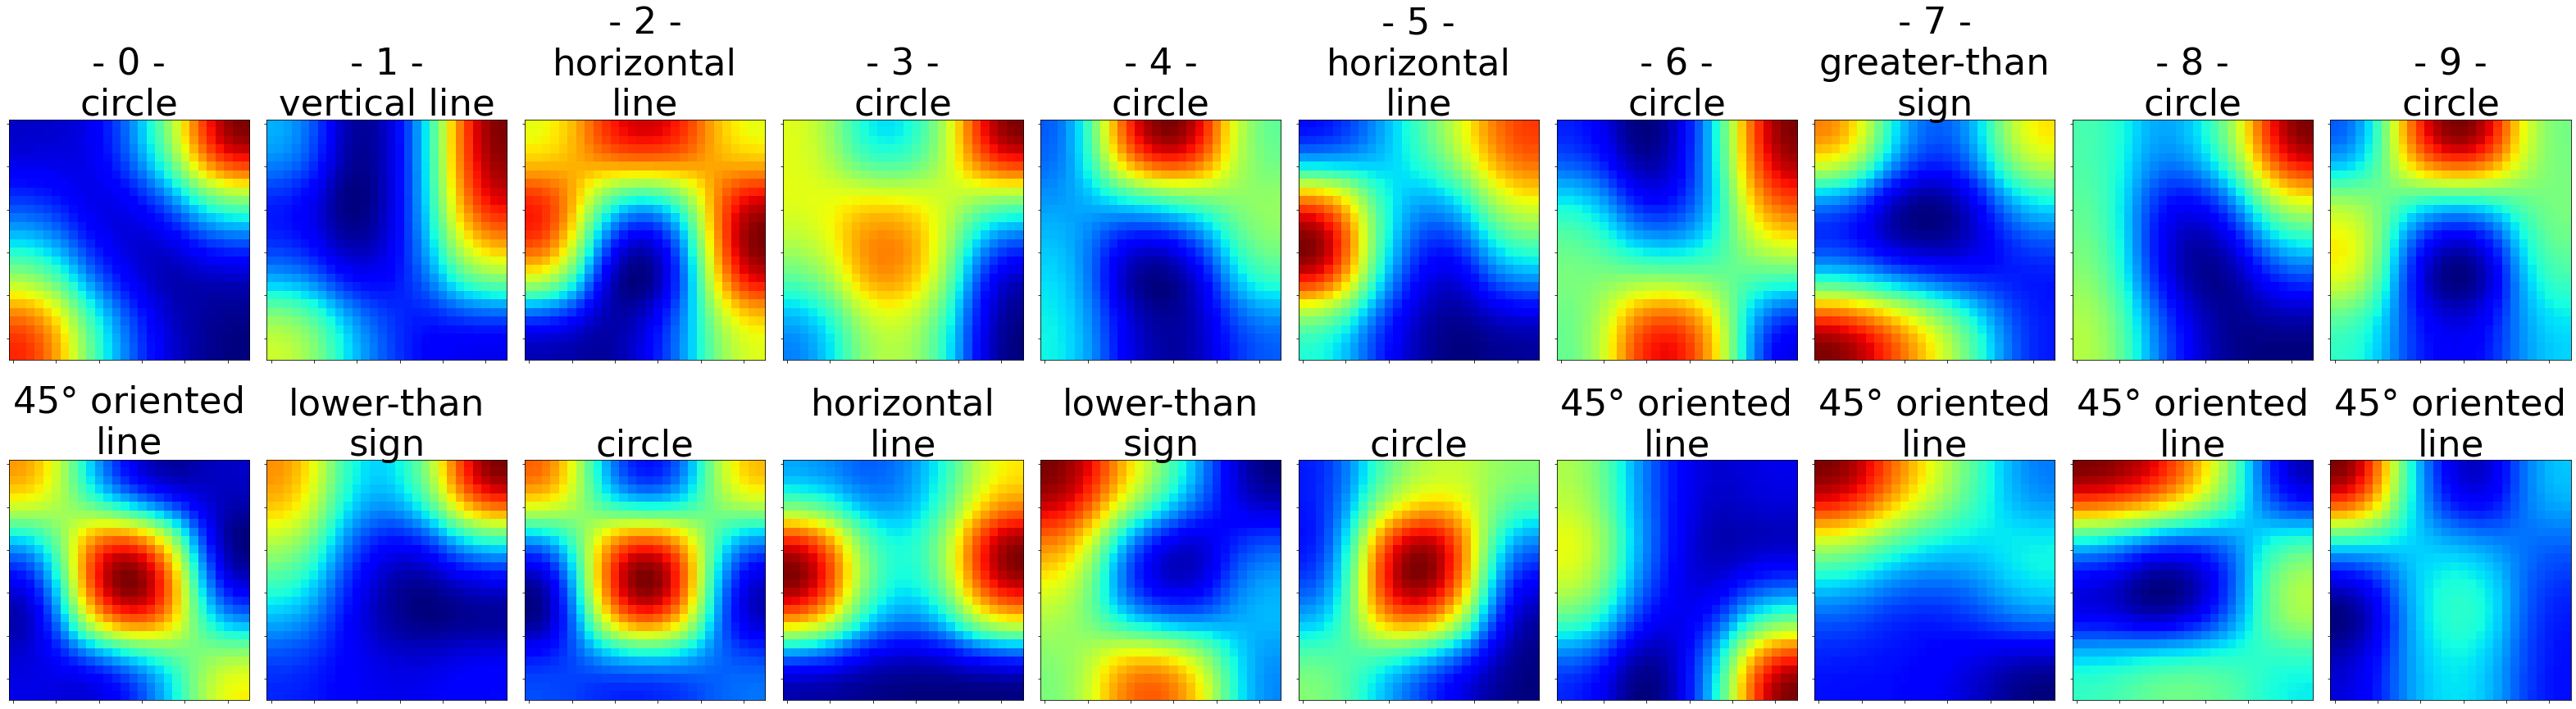

In [116]:
# grid image with the KDN category aggregation
image_idx = 0
fig = plt.figure(figsize=(56, 56))
grid = ImageGrid(fig, 111, nrows_ncols=(2, mnist_num_classes), axes_pad=(0.3, 1.7), label_mode="1", direction='column')

for mnist_category in range(mnist_num_classes):
  geo_category = descriptions[mnist_category]
  index = 0
  
  for geo_cat in sorted(geo_category, key=lambda k: len(geo_category[k]), reverse=True):
    heightmap = np.zeros((3, 3))
    if index == 0: 
      title = f"- {mnist_category} -           {dataset_labels[geo_cat]}"
    else:
      title = f"{dataset_labels[geo_cat]}"

    for grid_position in geo_category[geo_cat]:
      heightmap[grid_position] += 1
    
    heigthmap = get_heatmap(heightmap, mnist_shape, True)
    show_image(heigthmap, mnist_shape, title, ax=grid[image_idx], cmap='jet', fontsize=45)
    image_idx += 1

    if index < 1: 
      index += 1
    else:
      break

plt.show()